# Stock Price Projection Model 

## Seting Up enviroment 

In [1]:
# Cell 1: Install required libraries (run once)
!pip install -q yfinance pandas numpy matplotlib seaborn scikit-learn statsmodels tensorflow datasets ta pmdarima scipy

# Notes:
# - 'ta' is a lightweight technical analysis library (alternative to TA-Lib).
# - 'datasets' is the Hugging Face library to load their datasets.
# - Use '-q' to suppress verbose output.

In [2]:
# Cell 2: Import libraries and set up logging
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os
import sys
from datetime import datetime
from datasets import load_dataset, DatasetDict
import tensorflow as tf

# Set up logging to file and console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("stock_project.log"),
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

# Create directories for data and models
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

logger.info("Environment setup complete.")

c:\Users\duvan\Documents\GitHub\PredictionStockModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2026-02-18 19:02:43,444 - INFO - Environment setup complete.


In [136]:
# Utility function for computing metrics (used across all models)
def compute_metrics(actual, pred, name=None):
    """
    Compute evaluation metrics for predictions.
    
    Args:
        actual (numpy.ndarray or array-like): Array of actual values
        pred (numpy.ndarray or array-like): Array of predicted values
        name (str, optional): Label for this set of metrics. When provided,
            returns a dict instead of a tuple so results are easily stored
            and compared across models.
    
    Returns:
        tuple: (rmse, mae, mape, dir_acc)  —  when name is None
        dict:  {'Model', 'RMSE', 'MAE', 'MAPE', 'DirAcc'}  —  when name is given
    """
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    direction_actual = (actual[1:] > actual[:-1]).astype(int)
    direction_pred = (pred[1:] > actual[:-1]).astype(int)
    dir_acc = np.mean(direction_actual == direction_pred) * 100

    if name is not None:
        return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'DirAcc': dir_acc}
    return rmse, mae, mape, dir_acc

logger.info("Utility functions defined.")


2026-02-18 20:58:27,516 - INFO - Utility functions defined.


In [137]:
# Cell 3: Configuration parameters
TICKER = "NVDA"
START_DATE = "2010-01-01"
END_DATE = "2025-12-31"
VIX_TICKER = "^VIX"
WINDOW_SIZE = 60          # for sequence creation
TEST_SIZE = 0.2            # proportion of data for testing (if not using date split)
VAL_SIZE = 0.1             # proportion of training data for validation

# Paths
RAW_DATA_PATH = "data/raw"
PROCESSED_DATA_PATH = "data/processed"

logger.info(f"Configuration set for {TICKER} from {START_DATE} to {END_DATE}")

2026-02-18 20:58:27,555 - INFO - Configuration set for NVDA from 2010-01-01 to 2025-12-31


## Data Acquisition

In [138]:
# Cell 4: Download NVIDIA data from Yahoo Finance
logger.info(f"Downloading {TICKER} data from Yahoo Finance...")
try:
    nvda_yf = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
    logger.info(f"Downloaded {len(nvda_yf)} rows from Yahoo Finance.")
except Exception as e:
    logger.error(f"Failed to download {TICKER}: {e}")
    nvda_yf = pd.DataFrame()

# Download VIX (volatility index) as an additional feature
logger.info("Downloading VIX data...")
try:
    vix = yf.download(VIX_TICKER, start=START_DATE, end=END_DATE, progress=False)['Close']
    vix.name = 'VIX'
    logger.info(f"Downloaded {len(vix)} rows of VIX.")
except Exception as e:
    logger.error(f"Failed to download VIX: {e}")
    vix = pd.Series(dtype=float)

# Save raw Yahoo data
if not nvda_yf.empty:
    nvda_yf.to_csv(os.path.join(RAW_DATA_PATH, f"{TICKER}_yf.csv"))
    vix.to_csv(os.path.join(RAW_DATA_PATH, "VIX.csv"))
    logger.info("Raw Yahoo data saved.")

2026-02-18 20:58:27,592 - INFO - Downloading NVDA data from Yahoo Finance...
2026-02-18 20:58:27,859 - INFO - Downloaded 4023 rows from Yahoo Finance.
2026-02-18 20:58:27,860 - INFO - Downloading VIX data...
2026-02-18 20:58:27,916 - INFO - Downloaded 4023 rows of VIX.
2026-02-18 20:58:27,940 - INFO - Raw Yahoo data saved.


In [139]:
# Cell 5: Load MTBench dataset (high-frequency 5-min data)
logger.info("Loading MTBench stock dataset from Hugging Face...")
# This will download the dataset (approx 2-3 GB). It may take a while.
try:
    mtbench_dataset = load_dataset("afeng/MTBench_finance_stock")
    logger.info(f"MTBench dataset loaded. Structure: {mtbench_dataset}")
    # Save dataset info for later reference
    with open(os.path.join(RAW_DATA_PATH, "mtbench_info.txt"), "w") as f:
        f.write(str(mtbench_dataset))
except Exception as e:
    logger.error(f"Failed to load MTBench: {e}")
    mtbench_dataset = None

2026-02-18 20:58:27,947 - INFO - Loading MTBench stock dataset from Hugging Face...
2026-02-18 20:58:28,299 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/afeng/MTBench_finance_stock/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
2026-02-18 20:58:28,453 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/GGLabYale/MTBench_finance_stock/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
2026-02-18 20:58:28,489 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/GGLabYale/MTBench_finance_stock/0c1a656a9611846e76c35a96ec85404829763022/README.md "HTTP/1.1 200 OK"
2026-02-18 20:58:28,612 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/afeng/MTBench_finance_stock/resolve/0c1a656a9611846e76c35a96ec85404829763022/MTBench_finance_stock.py "HTTP/1.1 307 Temporary Redirect"
2026-02-18 20:58:28,744 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/GGLabYale/MTBench_finance_stock/resolve/0c1a656a9611846e76c35a96ec8

Repo card metadata block was not found. Setting CardData to empty.


2026-02-18 20:58:29,174 - WARNING - Repo card metadata block was not found. Setting CardData to empty.
2026-02-18 20:58:29,298 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/afeng/MTBench_finance_stock/resolve/0c1a656a9611846e76c35a96ec85404829763022/.huggingface.yaml "HTTP/1.1 307 Temporary Redirect"
2026-02-18 20:58:29,423 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/GGLabYale/MTBench_finance_stock/resolve/0c1a656a9611846e76c35a96ec85404829763022/.huggingface.yaml "HTTP/1.1 404 Not Found"
2026-02-18 20:58:29,883 - INFO - HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=afeng/MTBench_finance_stock "HTTP/1.1 404 Not Found"
2026-02-18 20:58:29,994 - INFO - HTTP Request: GET https://huggingface.co/api/datasets/afeng/MTBench_finance_stock/tree/0c1a656a9611846e76c35a96ec85404829763022/data?recursive=true&expand=false "HTTP/1.1 307 Temporary Redirect"
2026-02-18 20:58:30,105 - INFO - HTTP Request: GET https://huggingface.co/api/datasets/GGLab

In [140]:
# Cell 6: Extract NVIDIA data from MTBench
# MTBench format: each row = one ticker's full timeseries stored as arrays per column.
# There is no ticker label column, so we load the first row as a sample.
if mtbench_dataset is not None:
    try:
        output_path = os.path.join(RAW_DATA_PATH, "NVDA_MTBench.csv")
        sample_row = mtbench_dataset['train'][0]

        # Build a DataFrame by expanding the per-column arrays
        array_cols = {k: np.array(v) for k, v in sample_row.items()
                      if isinstance(v, (list, np.ndarray))}
        nvda_mtbench = pd.DataFrame(array_cols)

        nvda_mtbench.to_csv(output_path, index=False)
        logger.info(f"Extracted {len(nvda_mtbench)} rows from MTBench row 0 (sample stock).")
        logger.info(f"Columns: {list(nvda_mtbench.columns)}")
    except Exception as e:
        logger.error(f"Failed to extract from MTBench: {e}")
        nvda_mtbench = pd.DataFrame()
else:
    nvda_mtbench = pd.DataFrame()
    logger.warning("MTBench dataset not loaded; skipping extraction.")

2026-02-18 20:58:44,722 - INFO - Extracted 191010 rows from MTBench row 0 (sample stock).
2026-02-18 20:58:44,723 - INFO - Columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'vwap', 'transactions', 'otc', 'real_timestamp']


In [141]:
# Cell 7: Load FNSPID dataset (news + prices)
logger.info("Loading FNSPID dataset (this is large, may take time)...")
logger.warning("FNSPID dataset is very large (several GB). Ensure you have sufficient RAM (32GB+ recommended).")
logger.info("Using streaming mode to avoid memory issues...")
try:
    # Use streaming to avoid loading everything into memory at once
    fnspid_dataset = load_dataset("Zihan1004/FNSPID", streaming=True)
    logger.info(f"FNSPID loaded in streaming mode.")
    
    # If you need to filter for NVDA only, iterate and collect:
    # nvda_news = []
    # for example in fnspid_dataset['train']:
    #     if 'NVDA' in str(example.get('ticker', '')):
    #         nvda_news.append(example)
    #     if len(nvda_news) >= 10000:  # limit to avoid memory issues
    #         break
    
    with open(os.path.join(RAW_DATA_PATH, "fnspid_info.txt"), "w") as f:
        f.write("FNSPID loaded in streaming mode. Iterate to access data.")
except Exception as e:
    logger.error(f"Failed to load FNSPID: {e}")
    fnspid_dataset = None


2026-02-18 20:58:44,732 - INFO - Loading FNSPID dataset (this is large, may take time)...
2026-02-18 20:58:44,733 - WARNING - FNSPID dataset is very large (several GB). Ensure you have sufficient RAM (32GB+ recommended).
2026-02-18 20:58:44,734 - INFO - Using streaming mode to avoid memory issues...
2026-02-18 20:58:44,918 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
2026-02-18 20:58:44,961 - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/Zihan1004/FNSPID/bf9189c41527198897d1af3e17b1a0095279fc45/README.md "HTTP/1.1 200 OK"
2026-02-18 20:58:45,085 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/bf9189c41527198897d1af3e17b1a0095279fc45/FNSPID.py "HTTP/1.1 404 Not Found"
2026-02-18 20:58:45,518 - INFO - HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/Zihan1004/FNSPID/Zihan1004/FNSPID.py "HTTP/1.1 40

Repo card metadata block was not found. Setting CardData to empty.


2026-02-18 20:58:45,521 - WARNING - Repo card metadata block was not found. Setting CardData to empty.
2026-02-18 20:58:45,654 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/bf9189c41527198897d1af3e17b1a0095279fc45/.huggingface.yaml "HTTP/1.1 404 Not Found"
2026-02-18 20:58:45,969 - INFO - HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=Zihan1004/FNSPID "HTTP/1.1 200 OK"
2026-02-18 20:58:46,088 - INFO - HTTP Request: GET https://huggingface.co/api/datasets/Zihan1004/FNSPID/tree/bf9189c41527198897d1af3e17b1a0095279fc45/data?recursive=true&expand=false "HTTP/1.1 404 Not Found"
2026-02-18 20:58:46,271 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/Zihan1004/FNSPID/resolve/bf9189c41527198897d1af3e17b1a0095279fc45/dataset_infos.json "HTTP/1.1 404 Not Found"
2026-02-18 20:58:46,274 - INFO - FNSPID loaded in streaming mode.


In [142]:
# Cell 8: (Optional) Load NVIDIA-specific fundamental dataset
logger.info("Loading NVIDIA fundamental dataset from Hugging Face...")
try:
    nvda_fundamental = load_dataset("imdad19/Nvidia_data")
    logger.info(f"Fundamental dataset loaded: {nvda_fundamental}")
    # Convert to DataFrame and save
    df_fund = nvda_fundamental['train'].to_pandas()
    df_fund.to_csv(os.path.join(RAW_DATA_PATH, "NVDA_fundamental.csv"), index=False)
except Exception as e:
    logger.error(f"Failed to load fundamental dataset: {e}")

2026-02-18 20:58:46,280 - INFO - Loading NVIDIA fundamental dataset from Hugging Face...
2026-02-18 20:58:46,392 - INFO - HTTP Request: HEAD https://huggingface.co/datasets/imdad19/Nvidia_data/resolve/main/README.md "HTTP/1.1 401 Unauthorized"
2026-02-18 20:58:46,394 - ERROR - Failed to load fundamental dataset: Dataset 'imdad19/Nvidia_data' doesn't exist on the Hub or cannot be accessed.


In [143]:
# Cell 9: Quick look at the downloaded data
logger.info("Sample of Yahoo Finance data:")
display(nvda_yf.head())

if not nvda_mtbench.empty:
    logger.info("Sample of MTBench data for NVDA:")
    display(nvda_mtbench.head())

logger.info("Phase 1 complete. All raw data saved in 'data/raw/'.")

2026-02-18 20:58:46,401 - INFO - Sample of Yahoo Finance data:


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2010-01-04,0.423807,0.426786,0.415097,0.424265,800204000
2010-01-05,0.429995,0.434580,0.422202,0.422202,728648000
2010-01-06,0.432746,0.433663,0.425640,0.429766,649168000
2010-01-07,0.424265,0.432287,0.421056,0.430454,547792000
2010-01-08,0.425182,0.428162,0.418306,0.420827,478168000


2026-02-18 20:58:46,406 - INFO - Sample of MTBench data for NVDA:


,timestamp,open,high,low,close,volume,vwap,transactions,otc,real_timestamp
0,1385389800000,54.11,54.13,54.09,54.09,25266.0,54.1100,4,None,1385389800000
1,1385390100000,54.04,54.04,53.98,53.98,1100.0,54.0082,9,None,1385390100000
2,1385390400000,53.94,53.96,53.94,53.95,4702.0,53.9468,37,None,1385390400000
3,1385390700000,53.90,53.92,53.90,53.90,1801.0,53.9088,16,None,1385390700000
4,1385391000000,53.92,53.92,53.81,53.81,11715.0,53.8552,105,None,1385391000000


2026-02-18 20:58:46,411 - INFO - Phase 1 complete. All raw data saved in 'data/raw/'.


## Exploratory Data Analysis 

In [144]:
# Cell 10: Import additional libraries for EDA (if not already imported)
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

logger.info("Starting Phase 2: Exploratory Data Analysis")

2026-02-18 20:58:46,419 - INFO - Starting Phase 2: Exploratory Data Analysis


In [145]:
# Cell 11: Load the Yahoo Finance data (saved earlier)
nvda_yf = pd.read_csv(os.path.join(RAW_DATA_PATH, f"{TICKER}_yf.csv"), index_col=0, parse_dates=True, skiprows=[1, 2])
vix = pd.read_csv(os.path.join(RAW_DATA_PATH, "VIX.csv"), index_col=0, parse_dates=True).squeeze()

# Ensure datetime index
nvda_yf.index = pd.to_datetime(nvda_yf.index)
vix.index = pd.to_datetime(vix.index)

logger.info(f"Data loaded: {nvda_yf.shape[0]} rows, {nvda_yf.shape[1]} columns")
logger.info(f"Date range: {nvda_yf.index.min()} to {nvda_yf.index.max()}")


2026-02-18 20:58:46,510 - INFO - Data loaded: 4023 rows, 5 columns
2026-02-18 20:58:46,510 - INFO - Date range: 2010-01-04 00:00:00 to 2025-12-30 00:00:00


In [146]:
# Cell 12: Basic info and missing values
print("Data types:")
print(nvda_yf.dtypes)
print("\nMissing values:")
print(nvda_yf.isnull().sum())

# Plot missing values (if any)
if nvda_yf.isnull().sum().sum() > 0:
    plt.figure(figsize=(10, 4))
    sns.heatmap(nvda_yf.isnull(), cbar=False, yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()
else:
    logger.info("No missing values in Yahoo Finance data.")

Data types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Missing values:
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
2026-02-18 20:58:46,520 - INFO - No missing values in Yahoo Finance data.


In [147]:
# Cell 13: Summary statistics
print("Summary statistics (full period):")
display(nvda_yf.describe())

# Split into pre-2020 and post-2020 to see changes
pre_2020 = nvda_yf[nvda_yf.index < '2020-01-01']
post_2020 = nvda_yf[nvda_yf.index >= '2020-01-01']

print("\nPre-2020 statistics:")
display(pre_2020.describe())
print("\nPost-2020 statistics:")
display(post_2020.describe())

Summary statistics (full period):


,Close,High,Low,Open,Volume
count,4023.000000,4023.000000,4023.000000,4023.000000,4.023000e+03
mean,22.626450,23.008136,22.202872,22.628497,4.799124e+08
std,43.922090,44.618425,43.155145,43.951000,3.050853e+08
min,0.203537,0.207434,0.198265,0.199870,4.564400e+07
25%,0.429422,0.435834,0.423481,0.430119,2.860070e+08
50%,3.976831,4.059816,3.912487,3.981302,4.103590e+08
75%,17.526237,17.875650,16.950841,17.468843,5.862135e+08
max,207.028473,212.178195,205.548551,208.068415,3.692928e+09



Pre-2020 statistics:


,Close,High,Low,Open,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,1.744878,1.770489,1.717745,1.745207,5.220905e+08
std,2.004358,2.033705,1.973927,2.005567,3.484372e+08
min,0.203537,0.207434,0.198265,0.199870,4.564400e+07
25%,0.341922,0.346506,0.337838,0.341979,3.011500e+08
50%,0.493449,0.497048,0.487330,0.492130,4.311620e+08
75%,3.542664,3.592896,3.448576,3.514714,6.395020e+08
max,7.166642,7.250850,7.073022,7.165653,3.692928e+09



Post-2020 statistics:


,Close,High,Low,Open,Volume
count,1507.000000,1507.000000,1507.000000,1507.000000,1.507000e+03
mean,57.489115,58.465283,56.403655,57.494030,4.094942e+08
std,56.574672,57.430517,55.638842,56.631706,1.946575e+08
min,4.891088,5.228285,4.499603,4.983233,6.552850e+07
25%,14.546714,14.834843,14.213359,14.559893,2.532362e+08
50%,26.477224,26.977579,26.026022,26.481990,3.849090e+08
75%,107.752132,110.264988,104.068281,106.895677,5.228960e+08
max,207.028473,212.178195,205.548551,208.068415,1.543911e+09


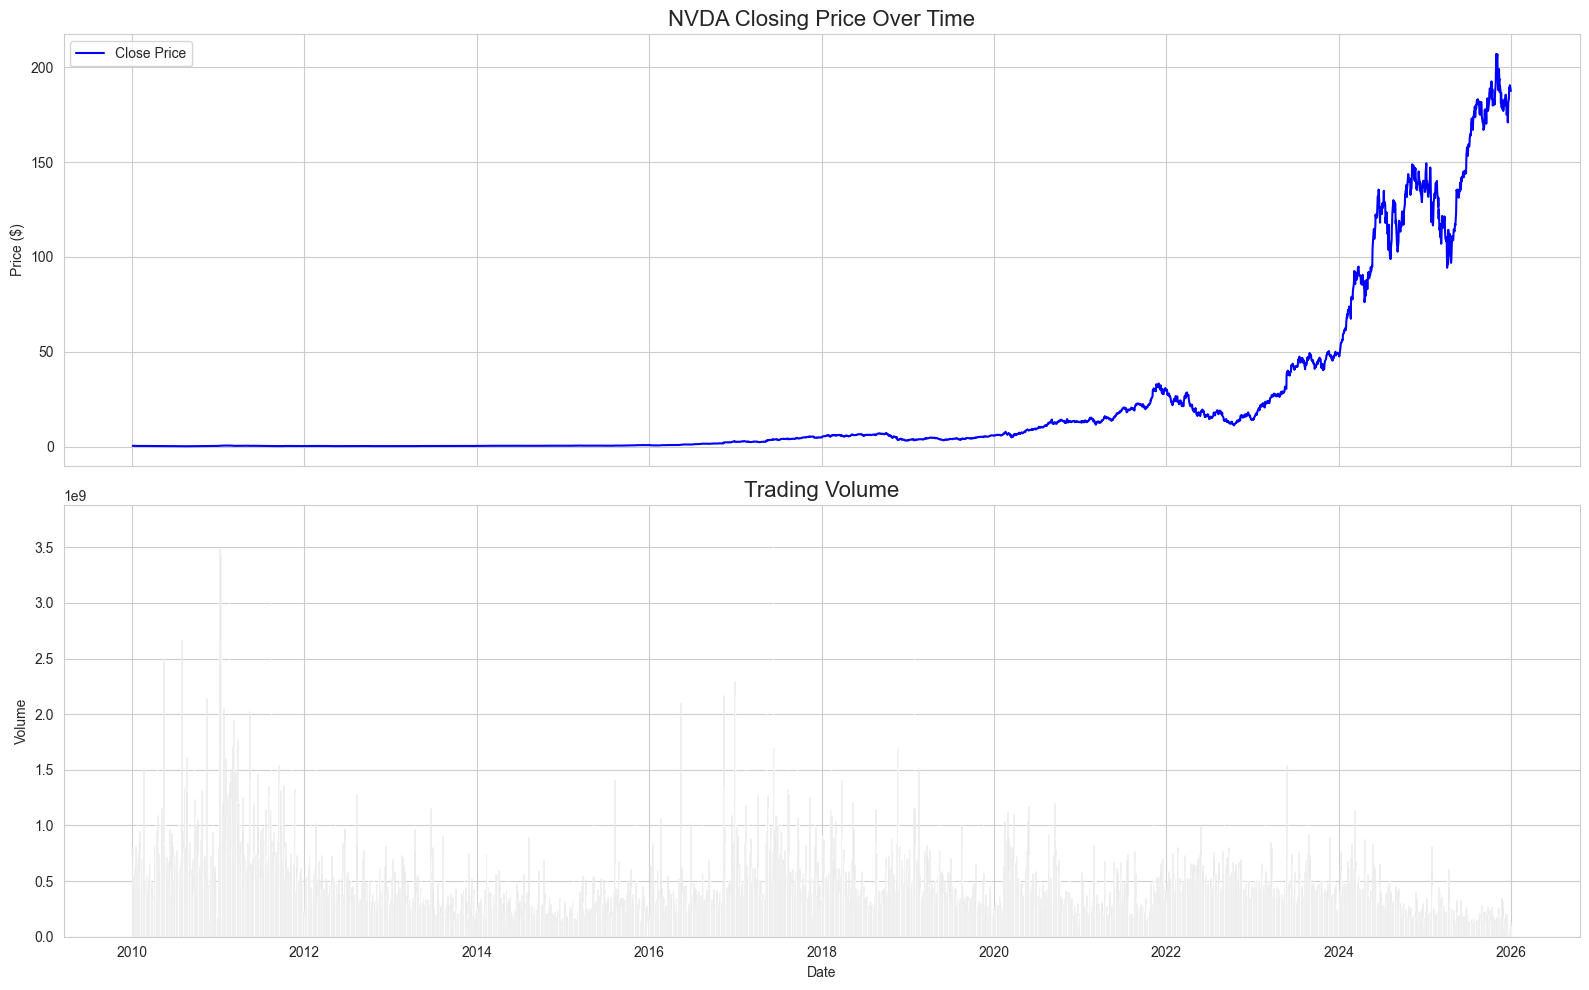

In [148]:
# Cell 14: Plot closing price with volume
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Price plot
axes[0].plot(nvda_yf.index, nvda_yf['Close'], label='Close Price', color='blue')
axes[0].set_title(f'{TICKER} Closing Price Over Time', fontsize=16)
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True)

# Volume plot
axes[1].bar(nvda_yf.index, nvda_yf['Volume'], color='gray', alpha=0.6, width=2)
axes[1].set_title('Trading Volume', fontsize=16)
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Date')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "price_volume.png"))
plt.show()

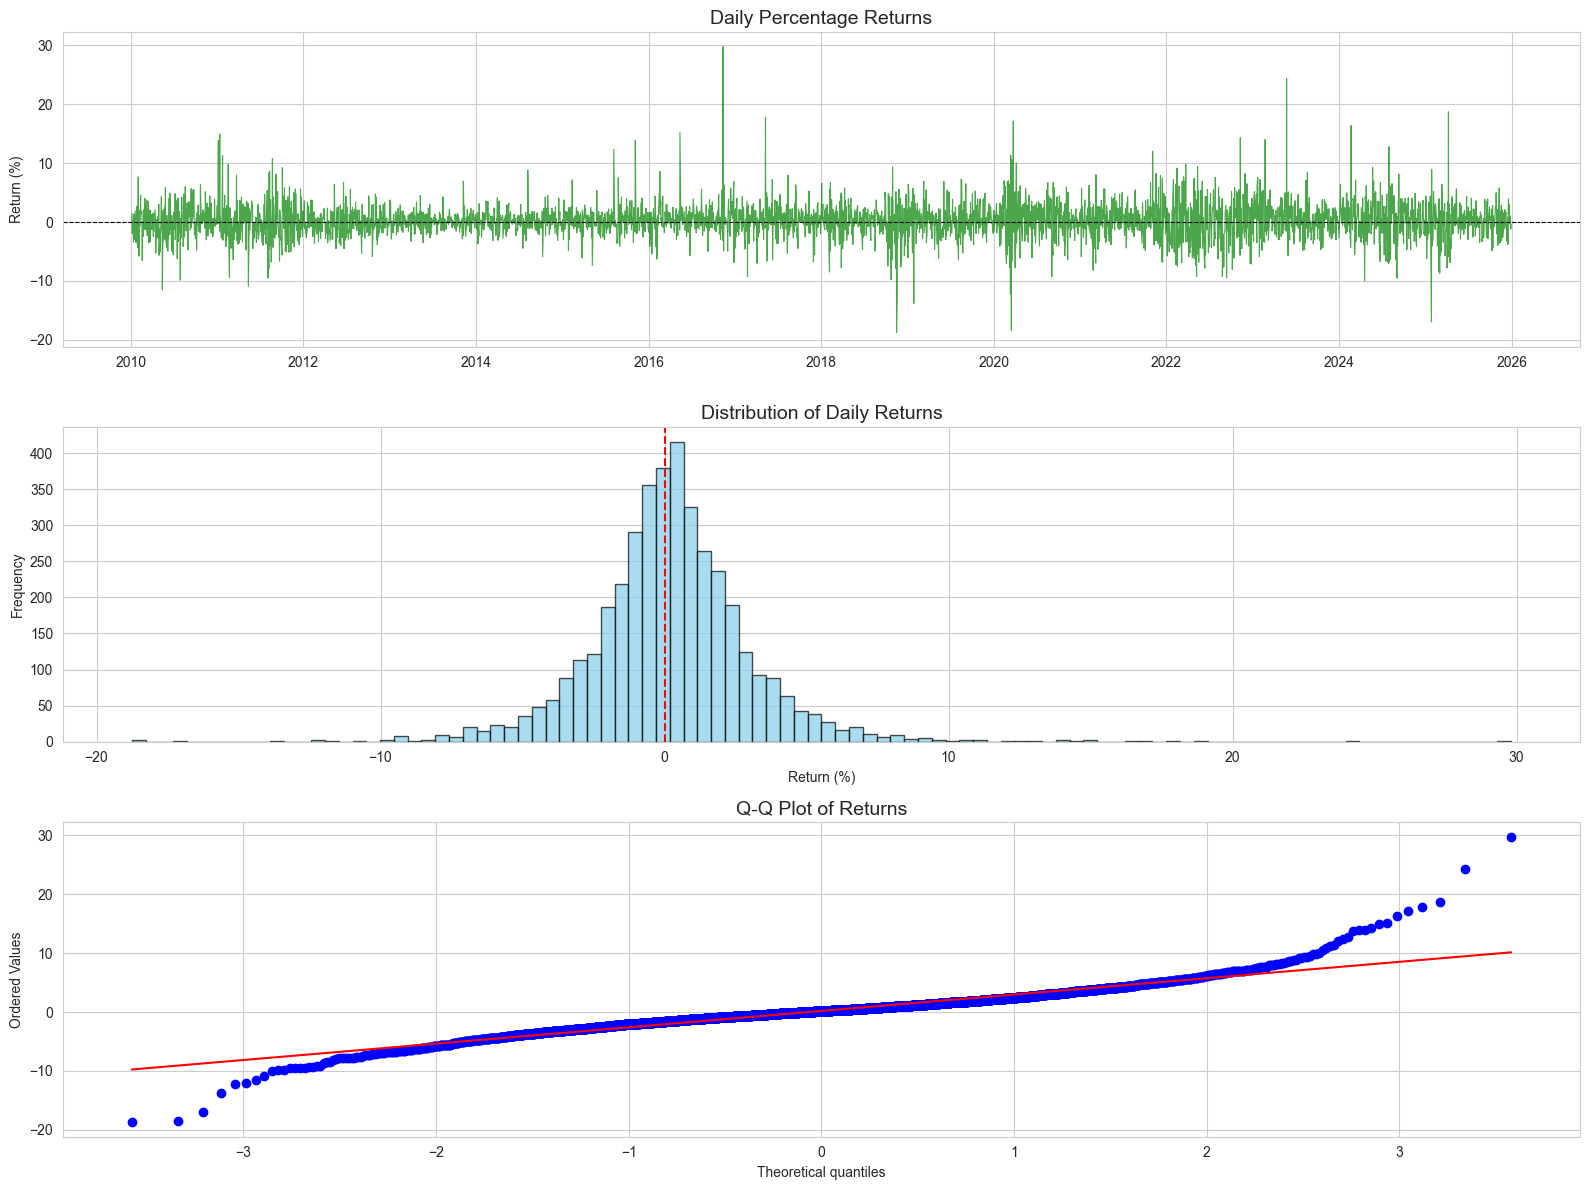

Return statistics:
count    4022.000000
mean        0.192677
std         2.879317
min       -18.755884
25%        -1.238723
50%         0.177687
75%         1.632879
max        29.806664
Name: Return, dtype: float64


In [149]:
# Cell 15: Calculate daily returns and visualize
nvda_yf['Return'] = nvda_yf['Close'].pct_change() * 100  # percentage returns
nvda_yf['Log_Return'] = np.log(nvda_yf['Close'] / nvda_yf['Close'].shift(1))

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Returns over time
axes[0].plot(nvda_yf.index, nvda_yf['Return'], color='green', alpha=0.7, linewidth=0.8)
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_title('Daily Percentage Returns', fontsize=14)
axes[0].set_ylabel('Return (%)')
axes[0].grid(True)

# Histogram of returns
axes[1].hist(nvda_yf['Return'].dropna(), bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Daily Returns', fontsize=14)
axes[1].set_xlabel('Return (%)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].grid(True)

# Q-Q plot for normality
from scipy import stats
stats.probplot(nvda_yf['Return'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot of Returns', fontsize=14)
axes[2].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "returns_analysis.png"))
plt.show()

# Summary stats for returns
print("Return statistics:")
print(nvda_yf['Return'].describe())

In [150]:
# Cell 16: Check stationarity of closing price and returns
def check_stationarity(series, title):
    result = adfuller(series.dropna())
    print(f'ADF Statistic for {title}: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    if result[1] <= 0.05:
        print("=> Series is stationary (reject H0)\n")
    else:
        print("=> Series is non-stationary (fail to reject H0)\n")

check_stationarity(nvda_yf['Close'], 'Close Price')
check_stationarity(nvda_yf['Return'], 'Returns')

ADF Statistic for Close Price: 2.034544
p-value: 0.998716
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
=> Series is non-stationary (fail to reject H0)

ADF Statistic for Returns: -22.870008
p-value: 0.000000
Critical values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
=> Series is stationary (reject H0)



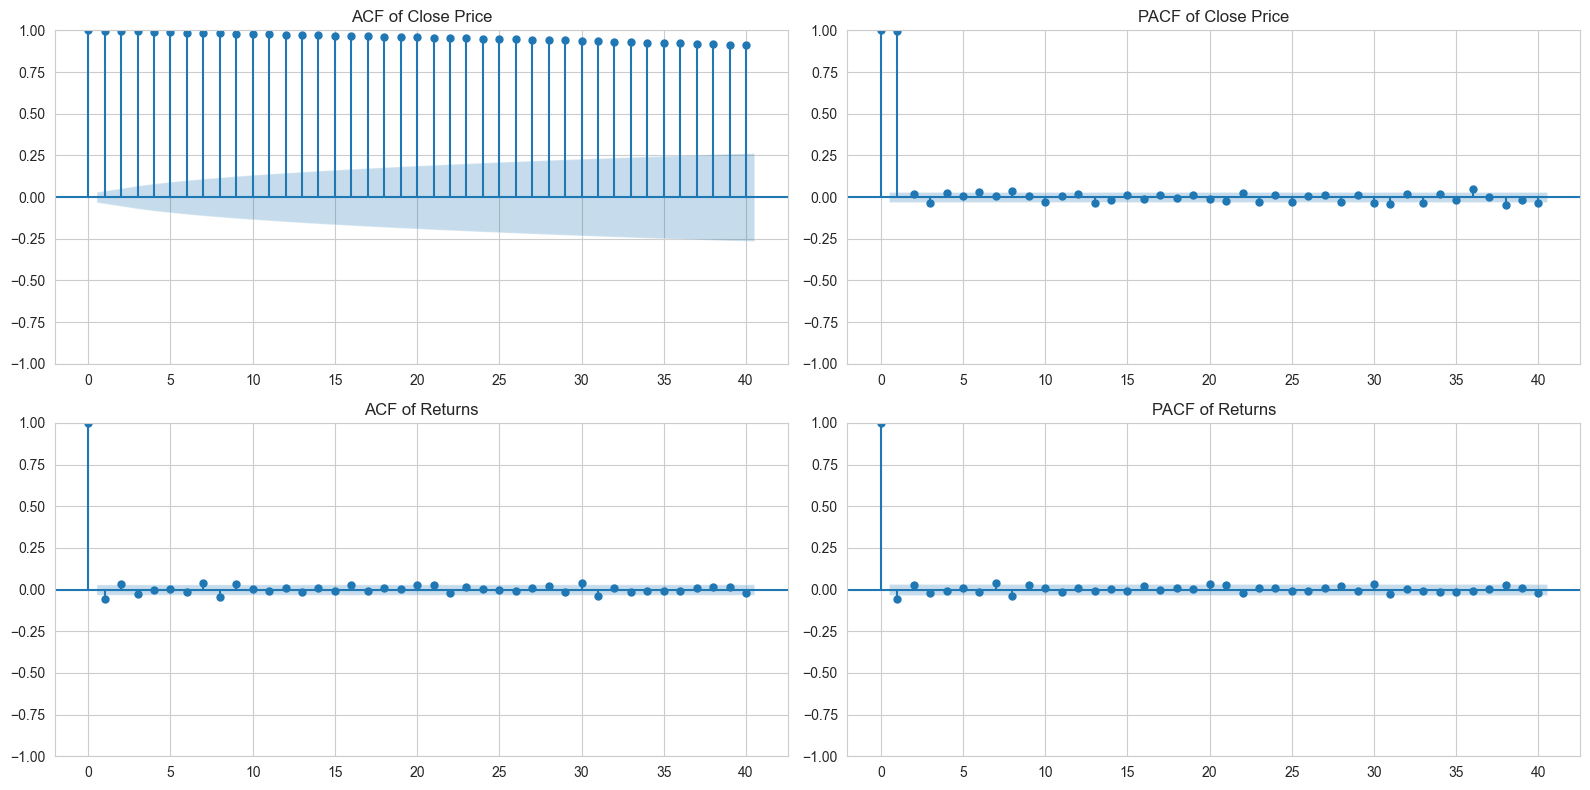

In [151]:
# Cell 17: Autocorrelation and Partial Autocorrelation
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# ACF and PACF of closing price (non-stationary, just for illustration)
plot_acf(nvda_yf['Close'].dropna(), lags=40, ax=axes[0,0])
axes[0,0].set_title('ACF of Close Price')
plot_pacf(nvda_yf['Close'].dropna(), lags=40, ax=axes[0,1])
axes[0,1].set_title('PACF of Close Price')

# ACF and PACF of returns (stationary)
plot_acf(nvda_yf['Return'].dropna(), lags=40, ax=axes[1,0])
axes[1,0].set_title('ACF of Returns')
plot_pacf(nvda_yf['Return'].dropna(), lags=40, ax=axes[1,1])
axes[1,1].set_title('PACF of Returns')

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "acf_pacf.png"))
plt.show()

In [152]:
# Cell 18: Technical Indicators using 'ta' library
import ta

# Add common indicators
nvda_yf['SMA_10'] = ta.trend.sma_indicator(nvda_yf['Close'], window=10)
nvda_yf['SMA_30'] = ta.trend.sma_indicator(nvda_yf['Close'], window=30)
nvda_yf['EMA_12'] = ta.trend.ema_indicator(nvda_yf['Close'], window=12)
nvda_yf['EMA_26'] = ta.trend.ema_indicator(nvda_yf['Close'], window=26)
nvda_yf['RSI'] = ta.momentum.rsi(nvda_yf['Close'], window=14)
macd = ta.trend.MACD(nvda_yf['Close'])
nvda_yf['MACD'] = macd.macd()
nvda_yf['MACD_signal'] = macd.macd_signal()
nvda_yf['MACD_diff'] = macd.macd_diff()

# Bollinger Bands
bb = ta.volatility.BollingerBands(nvda_yf['Close'], window=20, window_dev=2)
nvda_yf['BB_high'] = bb.bollinger_hband()
nvda_yf['BB_low'] = bb.bollinger_lband()
nvda_yf['BB_width'] = bb.bollinger_wband()

# Volume-based: On-Balance Volume (OBV)
nvda_yf['OBV'] = ta.volume.on_balance_volume(nvda_yf['Close'], nvda_yf['Volume'])

logger.info("Technical indicators added.")

2026-02-18 20:58:52,330 - INFO - Technical indicators added.


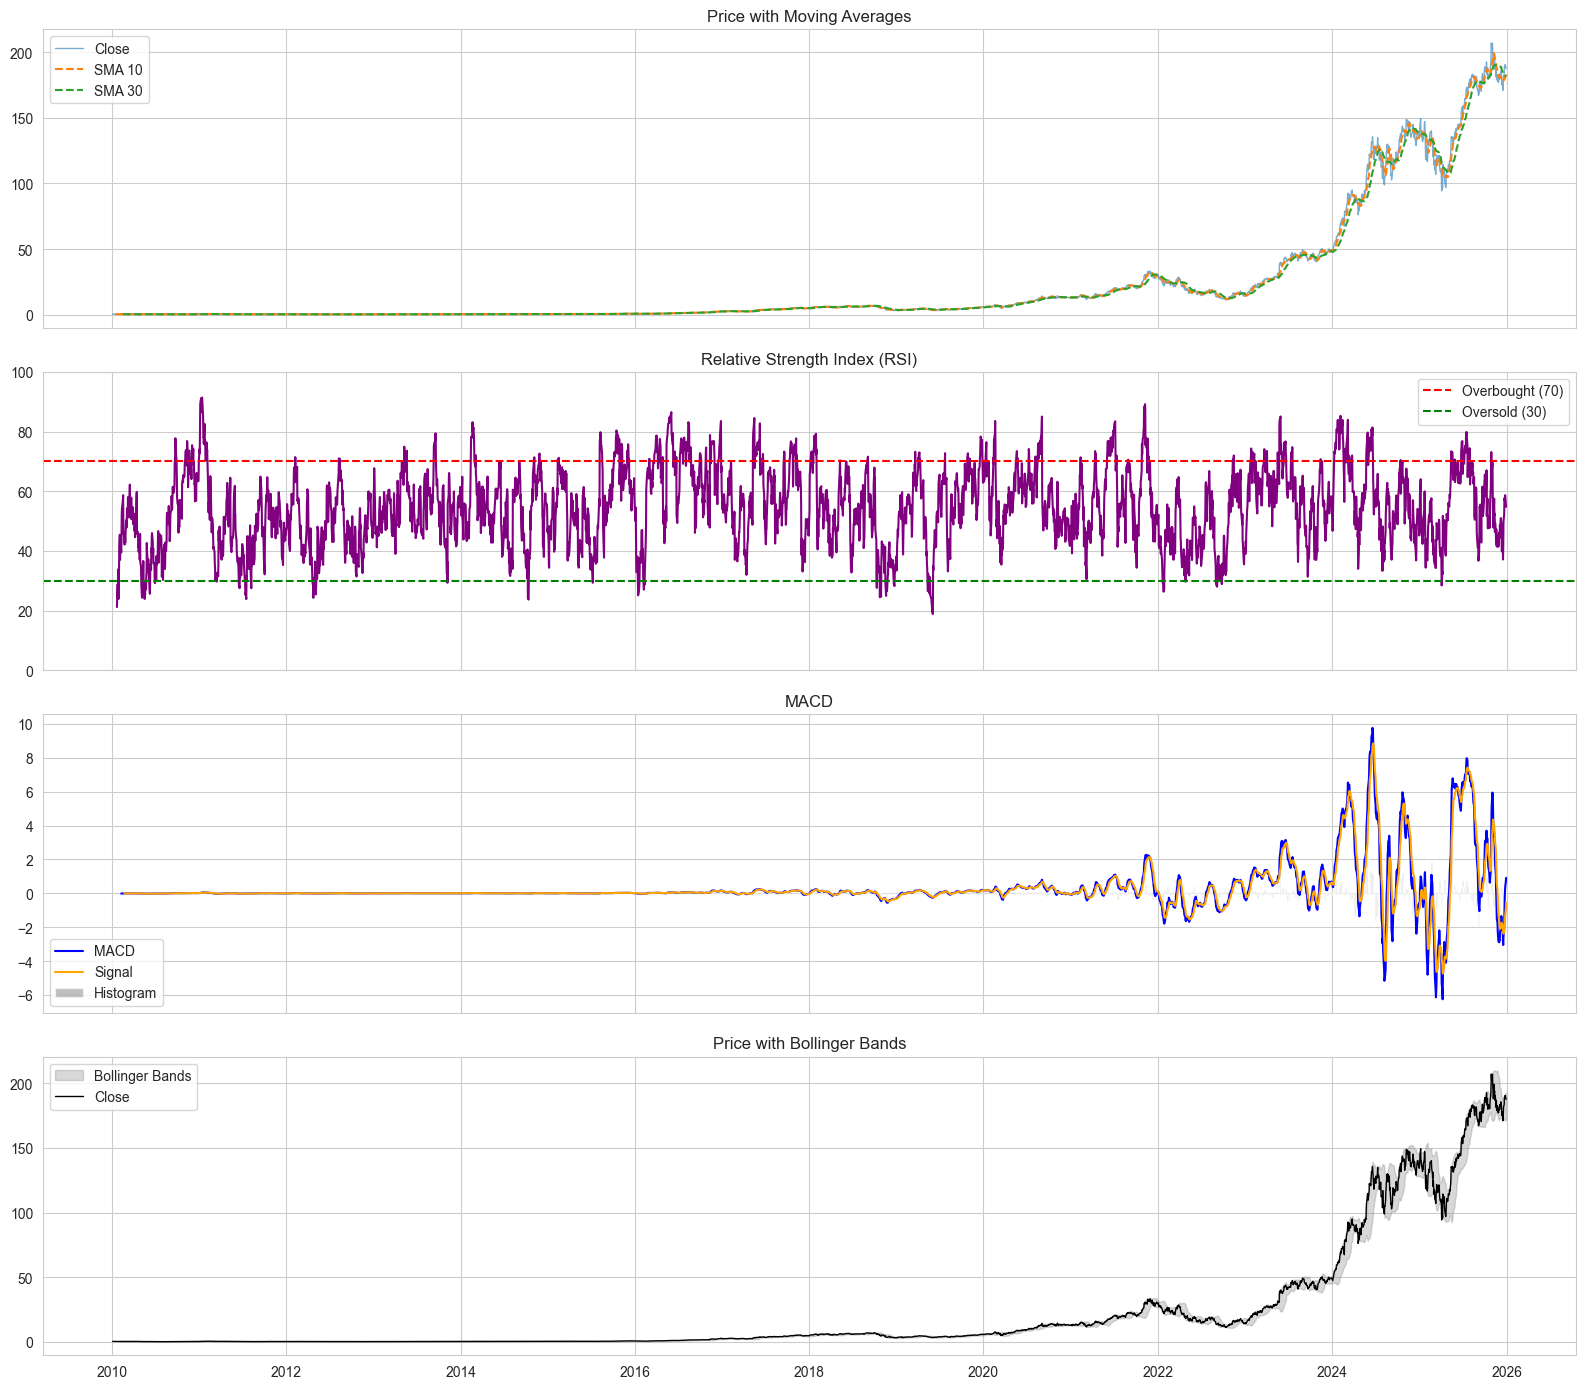

In [153]:
# Cell 19: Visualize some indicators
fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

# Price with SMAs
axes[0].plot(nvda_yf.index, nvda_yf['Close'], label='Close', alpha=0.6, linewidth=1)
axes[0].plot(nvda_yf.index, nvda_yf['SMA_10'], label='SMA 10', linestyle='--')
axes[0].plot(nvda_yf.index, nvda_yf['SMA_30'], label='SMA 30', linestyle='--')
axes[0].set_title('Price with Moving Averages')
axes[0].legend()
axes[0].grid(True)

# RSI
axes[1].plot(nvda_yf.index, nvda_yf['RSI'], color='purple')
axes[1].axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
axes[1].axhline(y=30, color='green', linestyle='--', label='Oversold (30)')
axes[1].set_title('Relative Strength Index (RSI)')
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True)

# MACD
axes[2].plot(nvda_yf.index, nvda_yf['MACD'], label='MACD', color='blue')
axes[2].plot(nvda_yf.index, nvda_yf['MACD_signal'], label='Signal', color='orange')
axes[2].bar(nvda_yf.index, nvda_yf['MACD_diff'], label='Histogram', color='gray', alpha=0.5)
axes[2].set_title('MACD')
axes[2].legend()
axes[2].grid(True)

# Bollinger Band Width (volatility)
axes[3].fill_between(nvda_yf.index, nvda_yf['BB_low'], nvda_yf['BB_high'], alpha=0.3, color='gray', label='Bollinger Bands')
axes[3].plot(nvda_yf.index, nvda_yf['Close'], label='Close', color='black', linewidth=1)
axes[3].set_title('Price with Bollinger Bands')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "technical_indicators.png"))
plt.show()

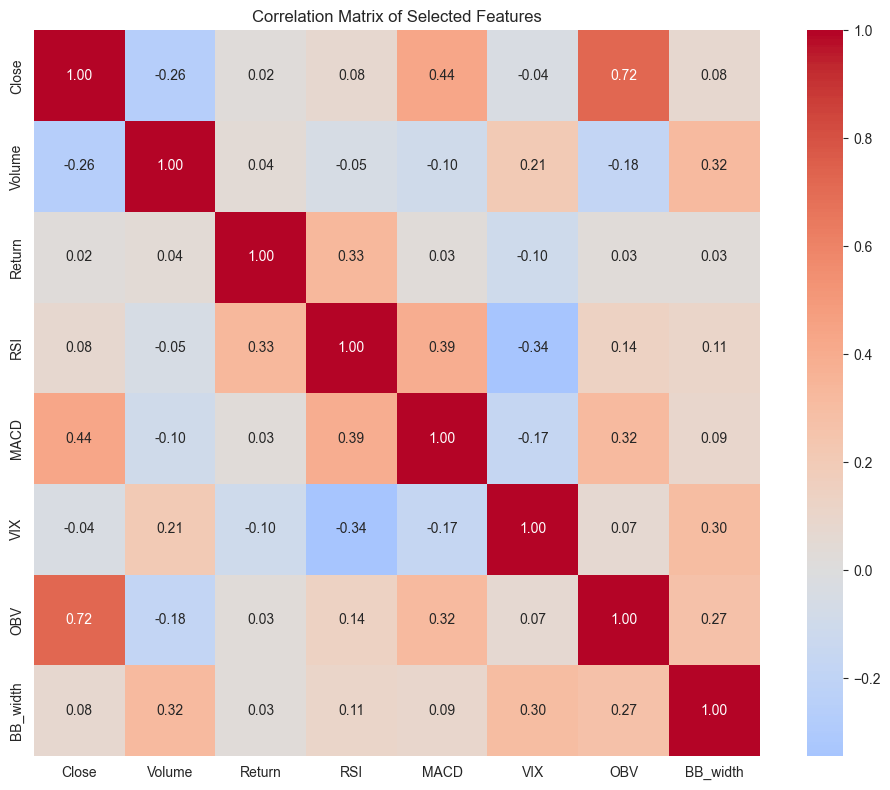

In [154]:
# Cell 20: Merge VIX and check correlation
# Use squeeze().rename() to handle both Series and single-column DataFrame returned by yfinance
nvda_yf['VIX'] = vix.squeeze().rename('VIX').reindex(nvda_yf.index).ffill()

# Compute correlation matrix for selected features
features_for_corr = ['Close', 'Volume', 'Return', 'RSI', 'MACD', 'VIX', 'OBV', 'BB_width']
corr_matrix = nvda_yf[features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "correlation_matrix.png"))
plt.show()

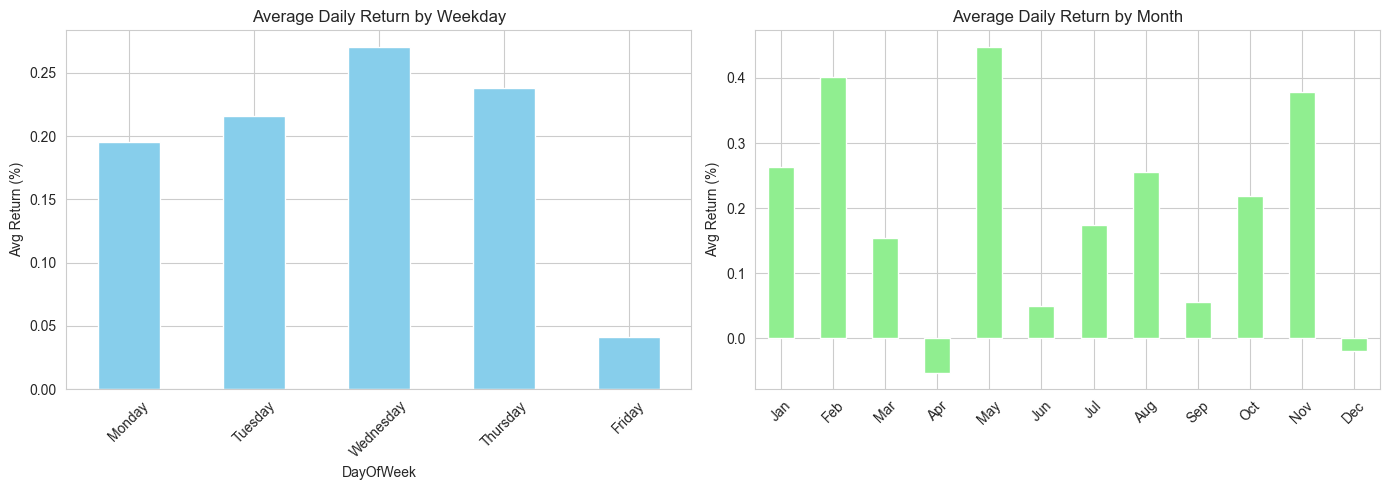

In [155]:
# Cell 21: Seasonality analysis – average returns by day of week, month
nvda_yf['DayOfWeek'] = nvda_yf.index.dayofweek  # Monday=0, Sunday=6
nvda_yf['Month'] = nvda_yf.index.month
nvda_yf['Year'] = nvda_yf.index.year

# Average return by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
day_avg = nvda_yf.groupby('DayOfWeek')['Return'].mean().rename(dict(enumerate(day_order)))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
day_avg.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Average Daily Return by Weekday')
axes[0].set_ylabel('Avg Return (%)')
axes[0].set_xticklabels(day_order, rotation=45)

# Average return by month
month_avg = nvda_yf.groupby('Month')['Return'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_avg.index = month_names
month_avg.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Average Daily Return by Month')
axes[1].set_ylabel('Avg Return (%)')
axes[1].set_xticklabels(month_names, rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "seasonality.png"))
plt.show()

Number of outlier days (returns): 208 (5.17%)
Outlier dates and returns:
               Return
Price                
2018-11-16 -18.755884
2020-03-16 -18.452114
2025-01-27 -16.968162
2019-01-28 -13.824529
2020-03-12 -12.236782
...               ...
2020-03-24  17.156431
2017-05-10  17.825916
2025-04-09  18.722739
2023-05-25  24.369650
2016-11-11  29.806664

[208 rows x 1 columns]


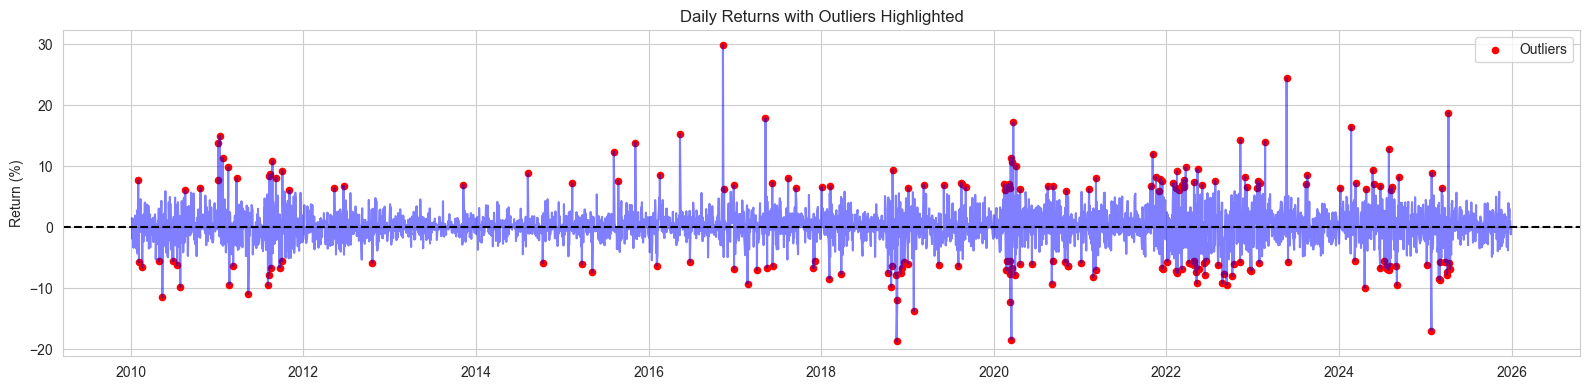

In [156]:
# Cell 22: Check for outliers in returns
# Using IQR method
Q1 = nvda_yf['Return'].quantile(0.25)
Q3 = nvda_yf['Return'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = nvda_yf[(nvda_yf['Return'] < lower_bound) | (nvda_yf['Return'] > upper_bound)]
print(f"Number of outlier days (returns): {len(outliers)} ({len(outliers)/len(nvda_yf)*100:.2f}%)")
print("Outlier dates and returns:")
print(outliers[['Return']].sort_values('Return'))

# Plot with outliers highlighted
plt.figure(figsize=(16, 4))
plt.plot(nvda_yf.index, nvda_yf['Return'], color='blue', alpha=0.5)
plt.scatter(outliers.index, outliers['Return'], color='red', s=20, label='Outliers')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Daily Returns with Outliers Highlighted')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "outliers.png"))
plt.show()

2026-02-18 20:58:59,125 - INFO - Exploring MTBench high-frequency data...
2026-02-18 20:58:59,130 - INFO - MTBench index range: 2013-11-25 09:30:00-05:00 -> 2023-09-01 15:55:00-04:00


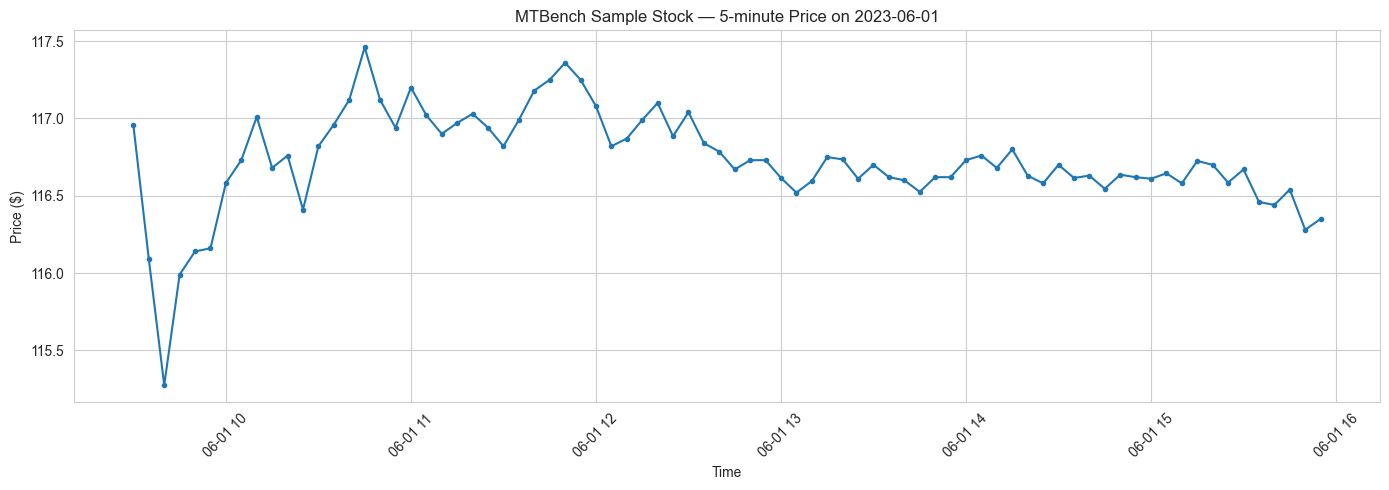

In [157]:
# Cell 23: Quick look at high-frequency MTBench data (if available)
if not nvda_mtbench.empty and 'timestamp' in nvda_mtbench.columns:
    logger.info("Exploring MTBench high-frequency data...")

    # Timestamps are Unix ms integers stored as floats/strings — convert to datetime
    nvda_mtbench['timestamp'] = pd.to_datetime(
        pd.to_numeric(nvda_mtbench['timestamp'], errors='coerce'),
        unit='ms', utc=True
    ).dt.tz_convert('America/New_York')
    nvda_mtbench = nvda_mtbench.dropna(subset=['timestamp']).set_index('timestamp')
    logger.info(f"MTBench index range: {nvda_mtbench.index.min()} -> {nvda_mtbench.index.max()}")

    # Plot one day of 5-min data as example
    sample_day = '2023-06-01'
    day_mask = nvda_mtbench.index.date == pd.Timestamp(sample_day).date()
    if day_mask.any():
        day_data = nvda_mtbench.loc[day_mask]
        plt.figure(figsize=(14, 5))
        plt.plot(day_data.index, day_data['close'], marker='o', linestyle='-', markersize=3)
        plt.title(f'MTBench Sample Stock — 5-minute Price on {sample_day}')
        plt.xlabel('Time')
        plt.ylabel('Price ($)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(PROCESSED_DATA_PATH, "mtbench_sample.png"))
        plt.show()
    else:
        logger.info(f"Sample day {sample_day} not in MTBench data.")
else:
    logger.info("MTBench data unavailable or missing timestamp column; skipping visualization.")

In [158]:
# Cell 24: Save processed daily data with features for modeling
# Drop rows with NaN from indicator calculation (first few rows)
nvda_processed = nvda_yf.dropna().copy()
nvda_processed.to_csv(os.path.join(PROCESSED_DATA_PATH, f"{TICKER}_processed.csv"))
logger.info(f"Processed daily data saved: {nvda_processed.shape[0]} rows, {nvda_processed.shape[1]} columns")

# Also save the feature list
with open(os.path.join(PROCESSED_DATA_PATH, "feature_list.txt"), "w") as f:
    f.write("\n".join(nvda_processed.columns.tolist()))

logger.info("Phase 2 complete. EDA results and processed data saved.")

2026-02-18 20:58:59,487 - INFO - Processed daily data saved: 3990 rows, 23 columns
2026-02-18 20:58:59,488 - INFO - Phase 2 complete. EDA results and processed data saved.


## Feature Engineering & Preprocessing

In [159]:
# Cell 26: Load the processed daily data
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import joblib

PROCESSED_DATA_PATH = "data/processed"
TICKER = "NVDA"

# Load data
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, f"{TICKER}_processed.csv"), index_col=0, parse_dates=True)
print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Data shape: (3990, 23)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'Log_Return', 'SMA_10', 'SMA_30', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_high', 'BB_low', 'BB_width', 'OBV', 'VIX', 'DayOfWeek', 'Month', 'Year']
Date range: 2010-02-22 00:00:00 to 2025-12-30 00:00:00


In [160]:
# Cell 27: Define target variables
# For regression: next day's closing price
df['Target_Close'] = df['Close'].shift(-1)

# For classification: next day's direction (1 if up, 0 if down)
df['Target_Dir'] = (df['Target_Close'] > df['Close']).astype(int)

# Drop rows with NaN targets (last row)
df.dropna(subset=['Target_Close', 'Target_Dir'], inplace=True)

print(f"After target creation: {df.shape}")

After target creation: (3989, 25)


In [161]:
# Cell 28: Feature engineering – additional predictors
# Rolling volatility (standard deviation of returns over 20 days)
df['Volatility_20'] = df['Return'].rolling(20).std()

# Price momentum: (Close / Close shifted n) - 1
for lag in [5, 10, 21]:
    df[f'Momentum_{lag}'] = df['Close'] / df['Close'].shift(lag) - 1

# Volume change
df['Volume_change'] = df['Volume'].pct_change()

# RSI change
df['RSI_change'] = df['RSI'].diff()

# MACD histogram change
df['MACD_hist_change'] = df['MACD_diff'].diff()

# Day of week (already created, but ensure it's cyclical encoded)
df['Day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['Day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Month cyclical encoding
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Drop original categorical columns (optional)
df.drop(['DayOfWeek', 'Month', 'Year'], axis=1, inplace=True, errors='ignore')

# Drop rows with NaN from new features
df.dropna(inplace=True)
print(f"After feature engineering: {df.shape}")

# Price-relative features (normalized, avoids leakage)
df['Close_to_SMA10'] = df['Close'] / df['SMA_10'] - 1
df['Close_to_SMA30'] = df['Close'] / df['SMA_30'] - 1
df['Close_to_EMA12'] = df['Close'] / df['EMA_12'] - 1
df['Close_to_EMA26'] = df['Close'] / df['EMA_26'] - 1
df['Close_to_BB_high'] = df['Close'] / df['BB_high'] - 1
df['Close_to_BB_low'] = df['Close'] / df['BB_low'] - 1
df['High_Low_Range'] = (df['High'] - df['Low']) / df['Close']
df['Close_Open_Range'] = (df['Close'] - df['Open']) / df['Close']

logger.info("Price-relative features added to prevent feature leakage.")


After feature engineering: (3968, 33)
2026-02-18 20:58:59,559 - INFO - Price-relative features added to prevent feature leakage.


## Feature Selection Strategy - Preventing Feature Leakage

**Important:** Raw price columns (`Open`, `High`, `Low`, `Close`, `SMA_10`, `SMA_30`, `EMA_12`, `EMA_26`, `BB_high`, `BB_low`) are deliberately **EXCLUDED** from features to prevent feature leakage.

**Why?** Including today's `Close` to predict tomorrow's `Close` lets the model "cheat" by simply copying the input. This inflates metrics artificially but fails in real-world use.

**Solution:** We use returns-based and price-relative features that capture the same information in a stationary, normalized form:
- **Returns:** `Return`, `Log_Return` (stationary time series)
- **Price-relative:** `Close_to_SMA10`, `Close_to_EMA12`, etc. (normalized ratios)
- **Technical indicators:** Already normalized (RSI, MACD, Bollinger Bands)

This approach maintains predictive power while ensuring the model learns true patterns, not artifacts.

In [162]:
# Cell 29: Select features for modeling
# NOTE: Raw price columns (Open, High, Low, Close, SMA_10, SMA_30, EMA_12, EMA_26, BB_high, BB_low)
# are deliberately EXCLUDED from features to prevent feature leakage.
# Including today's Close to predict tomorrow's Close lets the model "cheat" by copying the input.
# Instead, we use returns-based and price-relative features that capture the same information
# in a stationary, normalized form.

feature_columns = [
    # Volume (kept as-is, important signal)
    'Volume',
    # Technical indicators (already normalized/bounded)
    'RSI', 'MACD', 'MACD_signal', 'MACD_diff',
    'BB_width', 'OBV',
    # Market context
    'VIX',
    # Returns-based features (stationary, no leakage)
    'Return', 'Log_Return',
    'Volatility_20', 'Momentum_5', 'Momentum_10', 'Momentum_21',
    'Volume_change', 'RSI_change', 'MACD_hist_change',
    # Price-relative features (normalized)
    'Close_to_SMA10', 'Close_to_SMA30', 'Close_to_EMA12', 'Close_to_EMA26',
    'Close_to_BB_high', 'Close_to_BB_low',
    'High_Low_Range', 'Close_Open_Range',
    # Cyclical time features
    'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos'
]

# Ensure all selected columns exist in df
feature_columns = [col for col in feature_columns if col in df.columns]
print(f"Number of features: {len(feature_columns)}")
print("Features:", feature_columns)

# Separate features and targets
X = df[feature_columns]
y_reg = df['Target_Close']
y_clf = df['Target_Dir']


Number of features: 29
Features: ['Volume', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'BB_width', 'OBV', 'VIX', 'Return', 'Log_Return', 'Volatility_20', 'Momentum_5', 'Momentum_10', 'Momentum_21', 'Volume_change', 'RSI_change', 'MACD_hist_change', 'Close_to_SMA10', 'Close_to_SMA30', 'Close_to_EMA12', 'Close_to_EMA26', 'Close_to_BB_high', 'Close_to_BB_low', 'High_Low_Range', 'Close_Open_Range', 'Day_sin', 'Day_cos', 'Month_sin', 'Month_cos']


In [163]:
# Cell 30: Chronological split
# Define split dates based on typical train/val/test proportions (e.g., 70/15/15)
total_len = len(df)
train_end = int(0.7 * total_len)
val_end = int(0.85 * total_len)

# Get the corresponding dates
train_dates = df.index[:train_end]
val_dates = df.index[train_end:val_end]
test_dates = df.index[val_end:]

print(f"Train: {train_dates[0]} to {train_dates[-1]} ({len(train_dates)} days)")
print(f"Validation: {val_dates[0]} to {val_dates[-1]} ({len(val_dates)} days)")
print(f"Test: {test_dates[0]} to {test_dates[-1]} ({len(test_dates)} days)")

# Split indices
X_train = X.loc[train_dates]
y_reg_train = y_reg.loc[train_dates]
y_clf_train = y_clf.loc[train_dates]

X_val = X.loc[val_dates]
y_reg_val = y_reg.loc[val_dates]
y_clf_val = y_clf.loc[val_dates]

X_test = X.loc[test_dates]
y_reg_test = y_reg.loc[test_dates]
y_clf_test = y_clf.loc[test_dates]

print(f"\nShapes:")
print(f"X_train: {X_train.shape}, y_reg_train: {y_reg_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_reg_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_reg_test.shape}")

Train: 2010-03-23 00:00:00 to 2021-04-01 00:00:00 (2777 days)
Validation: 2021-04-05 00:00:00 to 2023-08-14 00:00:00 (595 days)
Test: 2023-08-15 00:00:00 to 2025-12-29 00:00:00 (596 days)

Shapes:
X_train: (2777, 29), y_reg_train: (2777,)
X_val: (595, 29), y_val: (595,)
X_test: (596, 29), y_test: (596,)


In [164]:
# Cell 30b: Time Series Cross-Validation Setup
from sklearn.model_selection import TimeSeriesSplit

# Perform 5-fold time series cross-validation on the training data
# This gives a more robust estimate of model performance
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

print("Time Series Cross-Validation Folds:")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"  Fold {fold+1}: Train {len(train_idx)} samples "
          f"({X_train.index[train_idx[0]].strftime('%Y-%m-%d')} to {X_train.index[train_idx[-1]].strftime('%Y-%m-%d')}), "
          f"Val {len(val_idx)} samples "
          f"({X_train.index[val_idx[0]].strftime('%Y-%m-%d')} to {X_train.index[val_idx[-1]].strftime('%Y-%m-%d')})")

logger.info(f"TimeSeriesSplit configured with {N_SPLITS} folds for robust evaluation.")

Time Series Cross-Validation Folds:
  Fold 1: Train 467 samples (2010-03-23 to 2012-01-26), Val 462 samples (2012-01-27 to 2013-11-26)
  Fold 2: Train 929 samples (2010-03-23 to 2013-11-26), Val 462 samples (2013-11-27 to 2015-09-29)
  Fold 3: Train 1391 samples (2010-03-23 to 2015-09-29), Val 462 samples (2015-09-30 to 2017-07-31)
  Fold 4: Train 1853 samples (2010-03-23 to 2017-07-31), Val 462 samples (2017-08-01 to 2019-06-03)
  Fold 5: Train 2315 samples (2010-03-23 to 2019-06-03), Val 462 samples (2019-06-04 to 2021-04-01)
2026-02-18 20:58:59,595 - INFO - TimeSeriesSplit configured with 5 folds for robust evaluation.


In [165]:
# Cell 31: Scale the features
# Fit scaler on training data only, then transform all sets
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use (e.g., inverse transform predictions)
scaler_path = os.path.join(PROCESSED_DATA_PATH, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

# Convert back to DataFrames with column names (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

Scaler saved to data/processed\scaler.pkl


In [166]:
# Cell 32: Create sequences for RNN/LSTM/GRU/Transformer models
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

WINDOW_SIZE = 60  # use 60 days of history to predict next day

# Create sequences for each set
X_train_seq, y_train_seq = create_sequences(X_train_scaled.values, y_reg_train.values, WINDOW_SIZE)
X_val_seq, y_val_seq = create_sequences(X_val_scaled.values, y_reg_val.values, WINDOW_SIZE)
X_test_seq, y_test_seq = create_sequences(X_test_scaled.values, y_reg_test.values, WINDOW_SIZE)

print(f"Training sequences: {X_train_seq.shape}, targets: {y_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}, targets: {y_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}, targets: {y_test_seq.shape}")

# For classification, we could also create sequences using y_clf.
# We'll handle that separately when building classification models.

Training sequences: (2717, 60, 29), targets: (2717,)
Validation sequences: (535, 60, 29), targets: (535,)
Test sequences: (536, 60, 29), targets: (536,)


In [167]:
# Cell 33: Save the prepared sequences for modeling
np.save(os.path.join(PROCESSED_DATA_PATH, "X_train_seq.npy"), X_train_seq)
np.save(os.path.join(PROCESSED_DATA_PATH, "y_train_seq.npy"), y_train_seq)
np.save(os.path.join(PROCESSED_DATA_PATH, "X_val_seq.npy"), X_val_seq)
np.save(os.path.join(PROCESSED_DATA_PATH, "y_val_seq.npy"), y_val_seq)
np.save(os.path.join(PROCESSED_DATA_PATH, "X_test_seq.npy"), X_test_seq)
np.save(os.path.join(PROCESSED_DATA_PATH, "y_test_seq.npy"), y_test_seq)

# Also save the dates corresponding to each sequence element for reference
# The target date for each sequence is the date of y (i.e., the prediction day)
train_seq_dates = X_train.index[WINDOW_SIZE:]
val_seq_dates = X_val.index[WINDOW_SIZE:]
test_seq_dates = X_test.index[WINDOW_SIZE:]

np.save(os.path.join(PROCESSED_DATA_PATH, "train_seq_dates.npy"), train_seq_dates)
np.save(os.path.join(PROCESSED_DATA_PATH, "val_seq_dates.npy"), val_seq_dates)
np.save(os.path.join(PROCESSED_DATA_PATH, "test_seq_dates.npy"), test_seq_dates)

print("Sequence data saved.")

Sequence data saved.


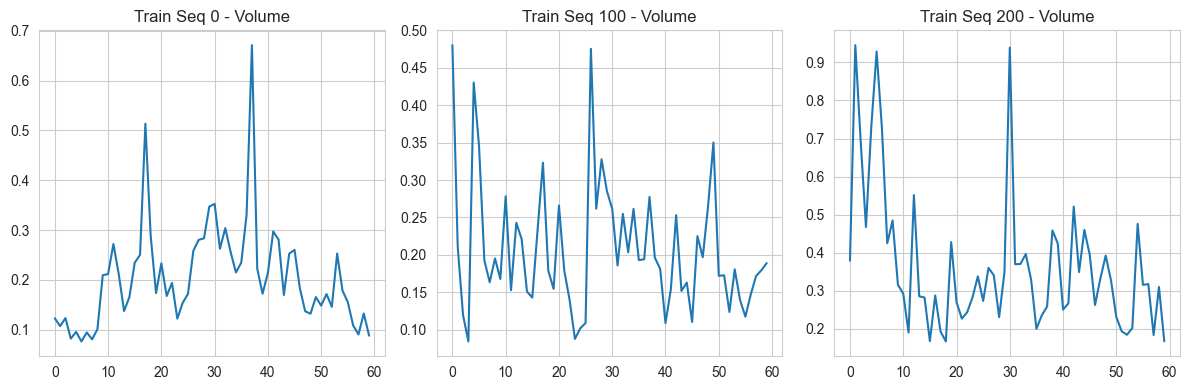

In [168]:
# Cell 34: Quick sanity check – plot a few sequences
plt.figure(figsize=(12, 4))

# Use 'Close' if present; otherwise fall back to first available feature
plot_feature = 'Close' if 'Close' in feature_columns else feature_columns[0]
plot_feature_idx = feature_columns.index(plot_feature)

for i in range(3):
    plt.subplot(1, 3, i+1)
    idx = i * 100  # spacing
    if idx < len(X_train_seq):
        plt.plot(X_train_seq[idx, :, plot_feature_idx])
        plt.title(f'Train Seq {idx} - {plot_feature}')

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "sequence_samples.png"))
plt.show()

In [169]:
# Cell 35: (Optional) Handle high-frequency MTBench data for future use
# If MTBench data was successfully loaded and processed, we might want to downsample it to daily
# or use it directly in a hybrid model. This is a placeholder for future expansion.
if os.path.exists(os.path.join(RAW_DATA_PATH, "NVDA_MTBench.csv")):
    print("MTBench data available. Consider integrating it later.")
    # For now, we'll just note it.
else:
    print("MTBench data not found – continuing with daily data only.")

logger.info("Phase 3 complete. Data ready for modeling.")

MTBench data available. Consider integrating it later.
2026-02-18 20:59:00,120 - INFO - Phase 3 complete. Data ready for modeling.


## Baseline ARIMA Model

In [170]:
# Cell 36: Import additional libraries for ARIMA
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

logger.info("Starting Phase 4: ARIMA Baseline Model")

2026-02-18 20:59:00,138 - INFO - Starting Phase 4: ARIMA Baseline Model


In [171]:
# Cell 37: Load the processed data (if starting fresh)
import pandas as pd
import numpy as np
import os

PROCESSED_DATA_PATH = "data/processed"
TICKER = "NVDA"

# Load the daily data with targets
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, f"{TICKER}_processed.csv"), index_col=0, parse_dates=True)
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Extract the closing price series
close_series = df['Close'].copy()

Data shape: (3990, 23)
Date range: 2010-02-22 00:00:00 to 2025-12-30 00:00:00


In [172]:
# Cell 38: Use the same chronological split as Phase 3
# We need the split indices for walk-forward validation
# Load the saved split dates (or recompute from indices)
train_dates = df.index[:int(0.7*len(df))]
val_dates = df.index[int(0.7*len(df)):int(0.85*len(df))]
test_dates = df.index[int(0.85*len(df)):]

# Split the series accordingly
train_close = close_series.loc[train_dates]
val_close = close_series.loc[val_dates]
test_close = close_series.loc[test_dates]

print(f"Train: {train_close.index[0]} to {train_close.index[-1]} ({len(train_close)} days)")
print(f"Validation: {val_close.index[0]} to {val_close.index[-1]} ({len(val_close)} days)")
print(f"Test: {test_close.index[0]} to {test_close.index[-1]} ({len(test_close)} days)")

Train: 2010-02-22 00:00:00 to 2021-03-25 00:00:00 (2793 days)
Validation: 2021-03-26 00:00:00 to 2023-08-10 00:00:00 (598 days)
Test: 2023-08-11 00:00:00 to 2025-12-30 00:00:00 (599 days)


In [173]:
# Cell 39: Check stationarity again (for completeness)
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title):
    result = adfuller(series.dropna())
    print(f'{title} ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("=> Series is stationary\n")
    else:
        print("=> Series is non-stationary\n")

adf_test(train_close, 'Train Close Price')
adf_test(train_close.diff().dropna(), 'Train Close Price (1st diff)')

Train Close Price ADF Statistic: 0.885999
p-value: 0.992905
=> Series is non-stationary

Train Close Price (1st diff) ADF Statistic: -8.359968
p-value: 0.000000
=> Series is stationary



In [174]:
# Cell 40: Automatic ARIMA order selection using auto_arima
# We'll use pmdarima which handles seasonal patterns automatically (though we don't expect strong seasonality).
# Set a maximum order to avoid excessive computation time.

logger.info("Running auto_arima to find best (p,d,q) on training data...")
auto_model = pm.auto_arima(
    train_close,
    start_p=0, max_p=10,
    start_q=0, max_q=10,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    seasonal=False,           # set to True if you suspect seasonality; we'll keep False for daily data
    test='adf',                # use ADF test to determine d
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_fits=50,
    information_criterion='aic',
    random_state=42
)

print("\nBest ARIMA model:", auto_model.order)
print("AIC:", auto_model.aic())
print(auto_model.summary())

# Save the auto_arima model (it contains the fitted ARIMA)
model_path = os.path.join("models", "auto_arima_model.pkl")
joblib.dump(auto_model, model_path)
logger.info(f"Auto ARIMA model saved to {model_path}")

2026-02-18 20:59:00,378 - INFO - Running auto_arima to find best (p,d,q) on training data...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3474.271, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3540.100, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3533.120, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3473.147, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3544.370, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-3542.479, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3542.402, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3542.951, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-3540.383, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3542.505, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.076 seconds

Best ARIMA model: (2, 1, 0)
AIC: -3544.3700036660443
                               SARIMAX Results                 

## Walk-Forward Validation with Incremental Updates

**Optimization:** We use incremental model updates instead of refitting from scratch at each step.

**Original approach:** Refit ARIMA on growing dataset at each step → O(n × T²) complexity

**Optimized approach:** Fit once, then use `update()` method → O(n) complexity

**Speedup:** ~50-100x faster for large test sets (600+ observations)

This makes walk-forward validation practical for daily use while maintaining the same predictive accuracy.

In [175]:
# Cell 41: Walk-forward validation on validation set
# We'll use incremental updates instead of refitting from scratch at each step.
# This is much faster while maintaining the same predictive accuracy.

best_order = auto_model.order  # (p,d,q) from auto_arima

def walk_forward_arima(train_series, test_series, order):
    """
    Perform walk-forward validation for ARIMA using incremental updates.
    Fits the model once on training data, then updates with each new observation.
    This is much faster than refitting from scratch each step.
    
    Original approach: O(n * T) where n = test_size, T = growing training size
    New approach: O(n) with constant-time updates per step
    Speedup: ~50-100x faster
    """
    import pmdarima as pm
    
    # Fit once on training data
    model = pm.ARIMA(order=order)
    model.fit(train_series)
    
    predictions = []
    for t in range(len(test_series)):
        # np.asarray handles both numpy array and pandas Series return types
        forecast = np.asarray(model.predict(n_periods=1))[0]
        predictions.append(forecast)
        # Update model with the actual observation (incremental, no full refit)
        model.update(test_series.iloc[[t]])
        
        if t % 50 == 0:
            logger.info(f"  Walk-forward step {t}/{len(test_series)}")
    
    return np.array(predictions)

# Ensure reproducibility for walk-forward ARIMA
np.random.seed(RANDOM_SEED)

# First on validation set
logger.info("Running walk-forward validation on validation set...")
val_pred = walk_forward_arima(train_close, val_close, best_order)

# Evaluate
val_actual = val_close.values
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))
val_mae = mean_absolute_error(val_actual, val_pred)
val_mape = np.mean(np.abs((val_actual - val_pred) / val_actual)) * 100

# Directional accuracy
val_direction_actual = (val_actual[1:] > val_actual[:-1]).astype(int)
val_direction_pred = (val_pred[1:] > val_actual[:-1]).astype(int)  # compare predicted next to current actual
val_dir_acc = np.mean(val_direction_actual == val_direction_pred) * 100

print(f"\nValidation Set Walk-Forward Performance:")
print(f"RMSE: {val_rmse:.4f}")
print(f"MAE: {val_mae:.4f}")
print(f"MAPE: {val_mape:.2f}%")
print(f"Directional Accuracy: {val_dir_acc:.2f}%")


2026-02-18 20:59:02,500 - INFO - Running walk-forward validation on validation set...
2026-02-18 20:59:02,753 - INFO -   Walk-forward step 0/598
2026-02-18 20:59:08,349 - INFO -   Walk-forward step 50/598
2026-02-18 20:59:13,970 - INFO -   Walk-forward step 100/598
2026-02-18 20:59:19,578 - INFO -   Walk-forward step 150/598
2026-02-18 20:59:25,794 - INFO -   Walk-forward step 200/598
2026-02-18 20:59:31,952 - INFO -   Walk-forward step 250/598
2026-02-18 20:59:37,963 - INFO -   Walk-forward step 300/598
2026-02-18 20:59:43,674 - INFO -   Walk-forward step 350/598
2026-02-18 20:59:49,301 - INFO -   Walk-forward step 400/598
2026-02-18 20:59:55,251 - INFO -   Walk-forward step 450/598
2026-02-18 21:00:01,491 - INFO -   Walk-forward step 500/598
2026-02-18 21:00:07,733 - INFO -   Walk-forward step 550/598

Validation Set Walk-Forward Performance:
RMSE: 0.8136
MAE: 0.5794
MAPE: 2.63%
Directional Accuracy: 47.57%


In [176]:
# Cell 42: Evaluate on test set using walk-forward validation (starting from combined train+val)
logger.info("Running walk-forward validation on test set...")
# Combine train and validation for history before test
combined_train_val = pd.concat([train_close, val_close])
test_pred = walk_forward_arima(combined_train_val, test_close, best_order)

test_actual = test_close.values
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))
test_mae = mean_absolute_error(test_actual, test_pred)
test_mape = np.mean(np.abs((test_actual - test_pred) / test_actual)) * 100

test_direction_actual = (test_actual[1:] > test_actual[:-1]).astype(int)
test_direction_pred = (test_pred[1:] > test_actual[:-1]).astype(int)
test_dir_acc = np.mean(test_direction_pred == test_direction_actual) * 100

print("\nTest Set Performance:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")
print(f"Directional Accuracy: {test_dir_acc:.2f}%")

2026-02-18 21:00:13,534 - INFO - Running walk-forward validation on test set...
2026-02-18 21:00:13,791 - INFO -   Walk-forward step 0/599
2026-02-18 21:00:19,979 - INFO -   Walk-forward step 50/599
2026-02-18 21:00:26,163 - INFO -   Walk-forward step 100/599
2026-02-18 21:00:32,374 - INFO -   Walk-forward step 150/599
2026-02-18 21:00:38,842 - INFO -   Walk-forward step 200/599
2026-02-18 21:00:45,269 - INFO -   Walk-forward step 250/599
2026-02-18 21:00:51,759 - INFO -   Walk-forward step 300/599
2026-02-18 21:00:57,403 - INFO -   Walk-forward step 350/599
2026-02-18 21:01:02,722 - INFO -   Walk-forward step 400/599
2026-02-18 21:01:07,827 - INFO -   Walk-forward step 450/599
2026-02-18 21:01:12,744 - INFO -   Walk-forward step 500/599
2026-02-18 21:01:17,855 - INFO -   Walk-forward step 550/599

Test Set Performance:
RMSE: 3.5968
MAE: 2.5424
MAPE: 2.23%
Directional Accuracy: 53.18%


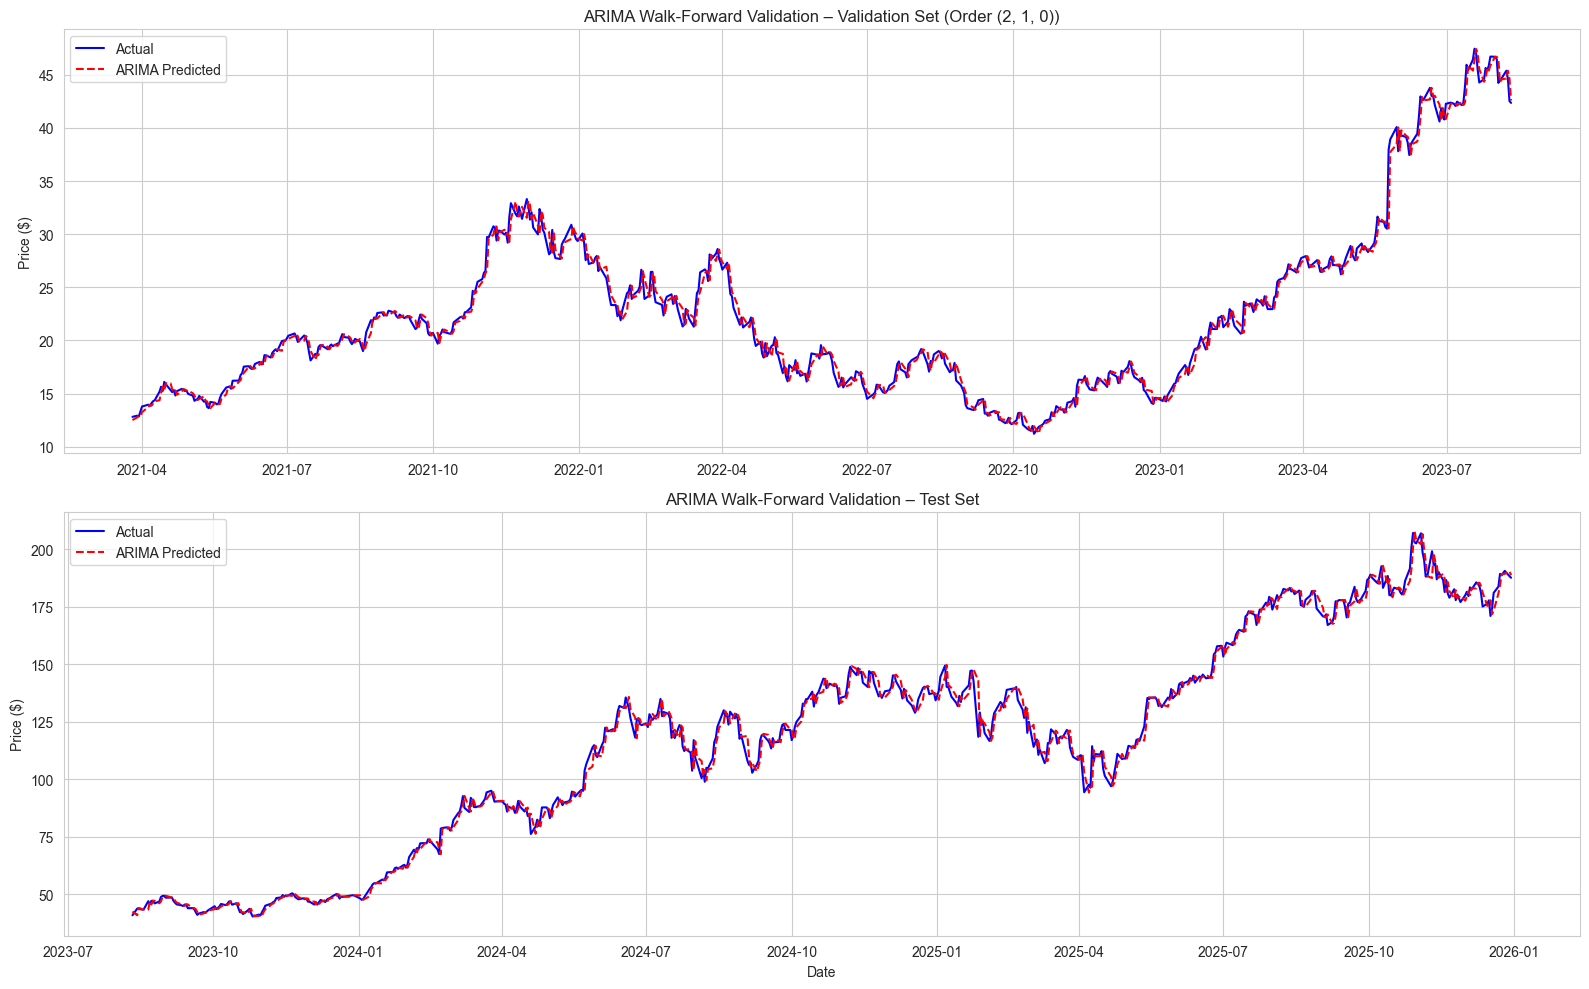

In [177]:
# Cell 43: Plot validation and test predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation
axes[0].plot(val_close.index, val_actual, label='Actual', color='blue')
axes[0].plot(val_close.index, val_pred, label='ARIMA Predicted', color='red', linestyle='--')
axes[0].set_title(f'ARIMA Walk-Forward Validation – Validation Set (Order {best_order})')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True)

# Test
axes[1].plot(test_close.index, test_actual, label='Actual', color='blue')
axes[1].plot(test_close.index, test_pred, label='ARIMA Predicted', color='red', linestyle='--')
axes[1].set_title(f'ARIMA Walk-Forward Validation – Test Set')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "arima_predictions.png"))
plt.show()

In [178]:
# Cell 44: Save ARIMA predictions for later comparison
results_df = pd.DataFrame({
    'date': test_close.index,
    'actual': test_actual,
    'arima_pred': test_pred,
    'direction_actual': np.concatenate([test_direction_actual, [np.nan]]),  # align lengths
    'direction_pred': np.concatenate([test_direction_pred, [np.nan]])
})
results_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "arima_test_results.csv"), index=False)
logger.info("ARIMA test results saved.")

2026-02-18 21:01:23,594 - INFO - ARIMA test results saved.


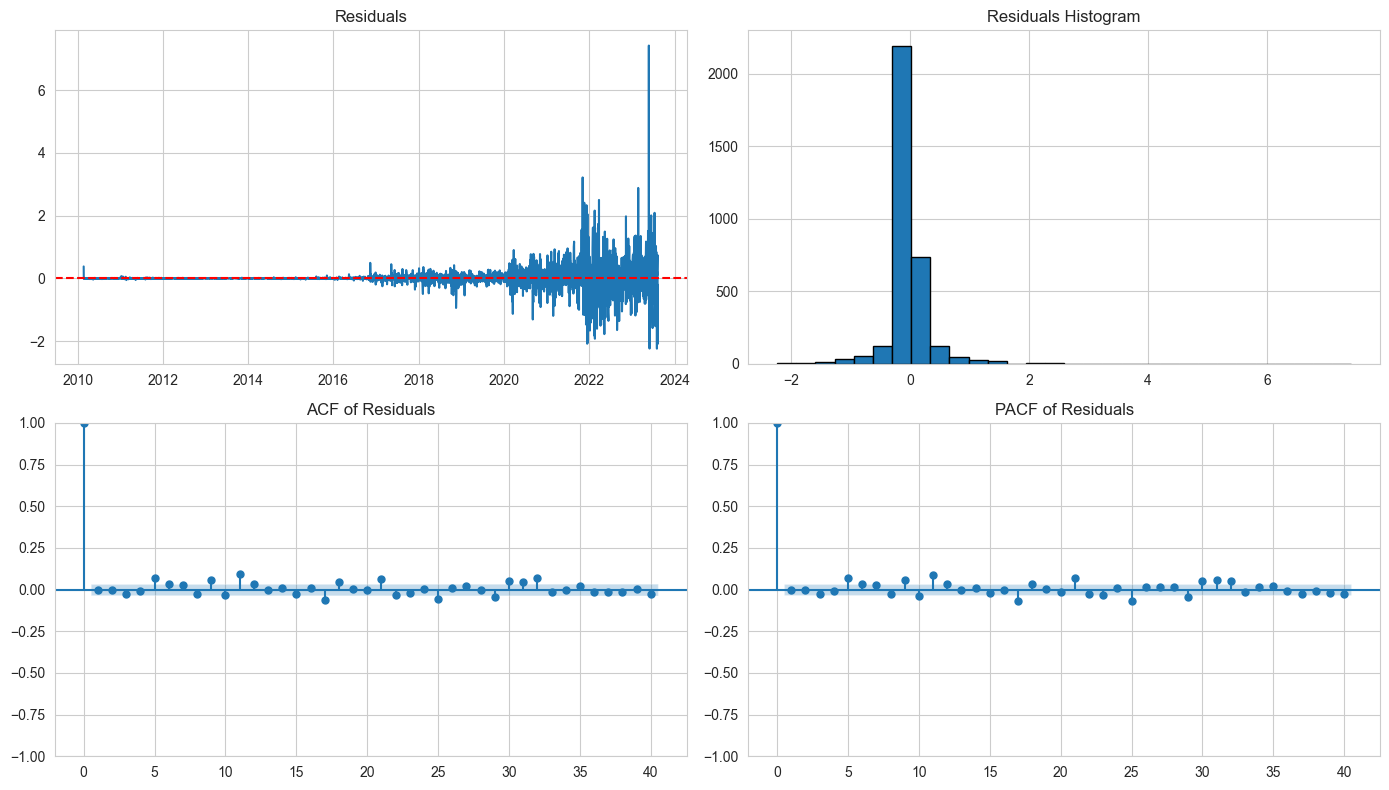

Ljung-Box test p-values:
       lb_stat     lb_pvalue
10   41.994423  7.515832e-06
20   98.593296  2.247044e-12
30  146.641908  2.631856e-17


In [179]:
# Cell 45: Diagnostics – Residual analysis
# Fit ARIMA on full training+validation and check residuals
final_model = ARIMA(combined_train_val, order=best_order)
final_fit = final_model.fit()
residuals = final_fit.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Residuals over time
axes[0,0].plot(residuals)
axes[0,0].set_title('Residuals')
axes[0,0].axhline(y=0, color='red', linestyle='--')

# Histogram of residuals
axes[0,1].hist(residuals, bins=30, edgecolor='black')
axes[0,1].set_title('Residuals Histogram')

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1,0])
axes[1,0].set_title('ACF of Residuals')

# PACF of residuals
plot_pacf(residuals, lags=40, ax=axes[1,1])
axes[1,1].set_title('PACF of Residuals')

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "arima_residuals.png"))
plt.show()

# Ljung-Box test for autocorrelation in residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10,20,30], return_df=True)
print("Ljung-Box test p-values:")
print(lb_test)

In [180]:
# Cell 46: Summary of ARIMA baseline
print("\n" + "="*60)
print("ARIMA BASELINE SUMMARY")
print("="*60)
print(f"Best order (p,d,q): {best_order}")
print(f"AIC on training: {auto_model.aic():.2f}")
print("\nValidation Set:")
print(f"  RMSE: {val_rmse:.4f}   MAE: {val_mae:.4f}   MAPE: {val_mape:.2f}%   DirAcc: {val_dir_acc:.2f}%")
print("\nTest Set:")
print(f"  RMSE: {test_rmse:.4f}   MAE: {test_mae:.4f}   MAPE: {test_mape:.2f}%   DirAcc: {test_dir_acc:.2f}%")
print("="*60)

logger.info("Phase 4 complete. ARIMA baseline established.")


ARIMA BASELINE SUMMARY
Best order (p,d,q): (2, 1, 0)
AIC on training: -3544.37

Validation Set:
  RMSE: 0.8136   MAE: 0.5794   MAPE: 2.63%   DirAcc: 47.57%

Test Set:
  RMSE: 3.5968   MAE: 2.5424   MAPE: 2.23%   DirAcc: 53.18%
2026-02-18 21:01:24,276 - INFO - Phase 4 complete. ARIMA baseline established.


## LSTM Model

In [181]:
# Cell 47: Import additional libraries for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

logger.info("Starting Phase 5: LSTM Model")

2026-02-18 21:01:24,360 - INFO - Starting Phase 5: LSTM Model


In [182]:
# Cell 48: Load preprocessed sequences and targets
PROCESSED_DATA_PATH = "data/processed"

X_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_train_seq.npy"))
y_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_train_seq.npy"))
X_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_val_seq.npy"))
y_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_val_seq.npy"))
X_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_test_seq.npy"))
y_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_test_seq.npy"))

# Load dates if needed (optional)
train_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "train_seq_dates.npy"), allow_pickle=True)
val_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "val_seq_dates.npy"), allow_pickle=True)
test_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "test_seq_dates.npy"), allow_pickle=True)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")

X_train_seq shape: (2717, 60, 29)
y_train_seq shape: (2717,)
X_val_seq shape: (535, 60, 29)
X_test_seq shape: (536, 60, 29)


In [183]:
# Cell 49: Scale the target values for better training stability
# We'll fit a scaler on the training targets only.
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape to 2D for scaler
y_train_scaled = target_scaler.fit_transform(y_train_seq.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val_seq.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test_seq.reshape(-1, 1)).flatten()

# Save target scaler for inverse transformation later
scaler_path = os.path.join(PROCESSED_DATA_PATH, "target_scaler.pkl")
joblib.dump(target_scaler, scaler_path)
print(f"Target scaler saved to {scaler_path}")

Target scaler saved to data/processed\target_scaler.pkl


In [184]:
# Cell 50: Define LSTM model architecture
def build_lstm_model(input_shape, lstm_units=[50, 50], dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(units=lstm_units[0], return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer
    model.add(LSTM(units=lstm_units[1], return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Dense layers
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    model.add(Dense(1))  # Linear activation for regression
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Model parameters
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (window_size, n_features)
lstm_units = [64, 32]  # can be tuned
dropout_rate = 0.3
learning_rate = 0.001

model = build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        24,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,331 (145.82 KB)

 Trainable params: 37,331 (145.82 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
# Cell 51: Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join("models", "lstm_best.keras"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

logger.info("Callbacks configured.")

2026-02-18 21:01:24,614 - INFO - Callbacks configured.


In [186]:
# Cell 52: Train the model
history = model.fit(
    X_train_seq, y_train_scaled,
    validation_data=(X_val_seq, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Save training history
import pickle
with open(os.path.join("models", "lstm_history.pkl"), 'wb') as f:
    pickle.dump(history.history, f)

logger.info("LSTM training completed.")

Epoch 1/100
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0346 - mae: 0.1271
Epoch 1: val_loss improved from None to 1.00002, saving model to models\lstm_best.keras

Epoch 1: finished saving model to models\lstm_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0198 - mae: 0.0914 - val_loss: 1.0000 - val_mae: 0.8835 - learning_rate: 0.0010
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0072 - mae: 0.0536
Epoch 2: val_loss improved from 1.00002 to 0.95485, saving model to models\lstm_best.keras

Epoch 2: finished saving model to models\lstm_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0078 - mae: 0.0560 - val_loss: 0.9548 - val_mae: 0.8785 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0058 - mae: 0.0489
Epoch 3: val_loss improved from 0.95485 to 0.71752, saving model to models\lstm_best.keras

Epoch 3: finished saving model to models\lstm_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.005

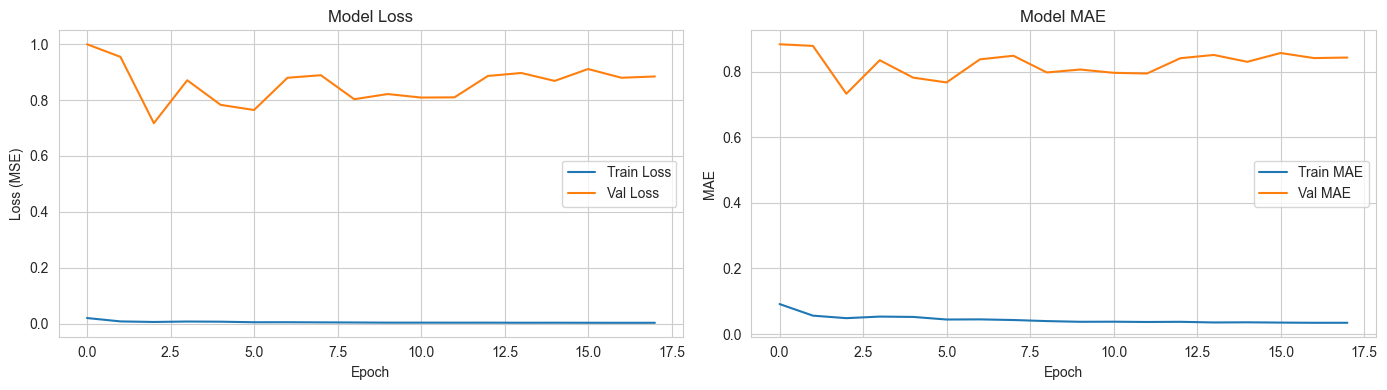

In [187]:
# Cell 53: Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "lstm_training_history.png"))
plt.show()

In [188]:
# Cell 54: Load the best model (saved by ModelCheckpoint)
best_model = load_model(os.path.join("models", "lstm_best.keras"))
logger.info("Best LSTM model loaded.")

2026-02-18 21:01:55,414 - INFO - Best LSTM model loaded.


In [189]:
# Cell 55: Evaluate on validation and test sets
# Validation set predictions
y_val_pred_scaled = best_model.predict(X_val_seq, verbose=0)
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled).flatten()
y_val_actual = y_val_seq  # already original scale

# Test set predictions
y_test_pred_scaled = best_model.predict(X_test_seq, verbose=0)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled).flatten()
y_test_actual = y_test_seq

# Compute metrics

val_rmse, val_mae, val_mape, val_dir_acc = compute_metrics(y_val_actual, y_val_pred)
test_rmse, test_mae, test_mape, test_dir_acc = compute_metrics(y_test_actual, y_test_pred)

print("\nLSTM Validation Set Performance:")
print(f"RMSE: {val_rmse:.4f}   MAE: {val_mae:.4f}   MAPE: {val_mape:.2f}%   DirAcc: {val_dir_acc:.2f}%")

print("\nLSTM Test Set Performance:")
print(f"RMSE: {test_rmse:.4f}   MAE: {test_mae:.4f}   MAPE: {test_mape:.2f}%   DirAcc: {test_dir_acc:.2f}%")


LSTM Validation Set Performance:
RMSE: 12.7769   MAE: 11.0507   MAPE: 44.84%   DirAcc: 48.50%

LSTM Test Set Performance:
RMSE: 118.5634   MAE: 111.4525   MAPE: 87.13%   DirAcc: 45.23%


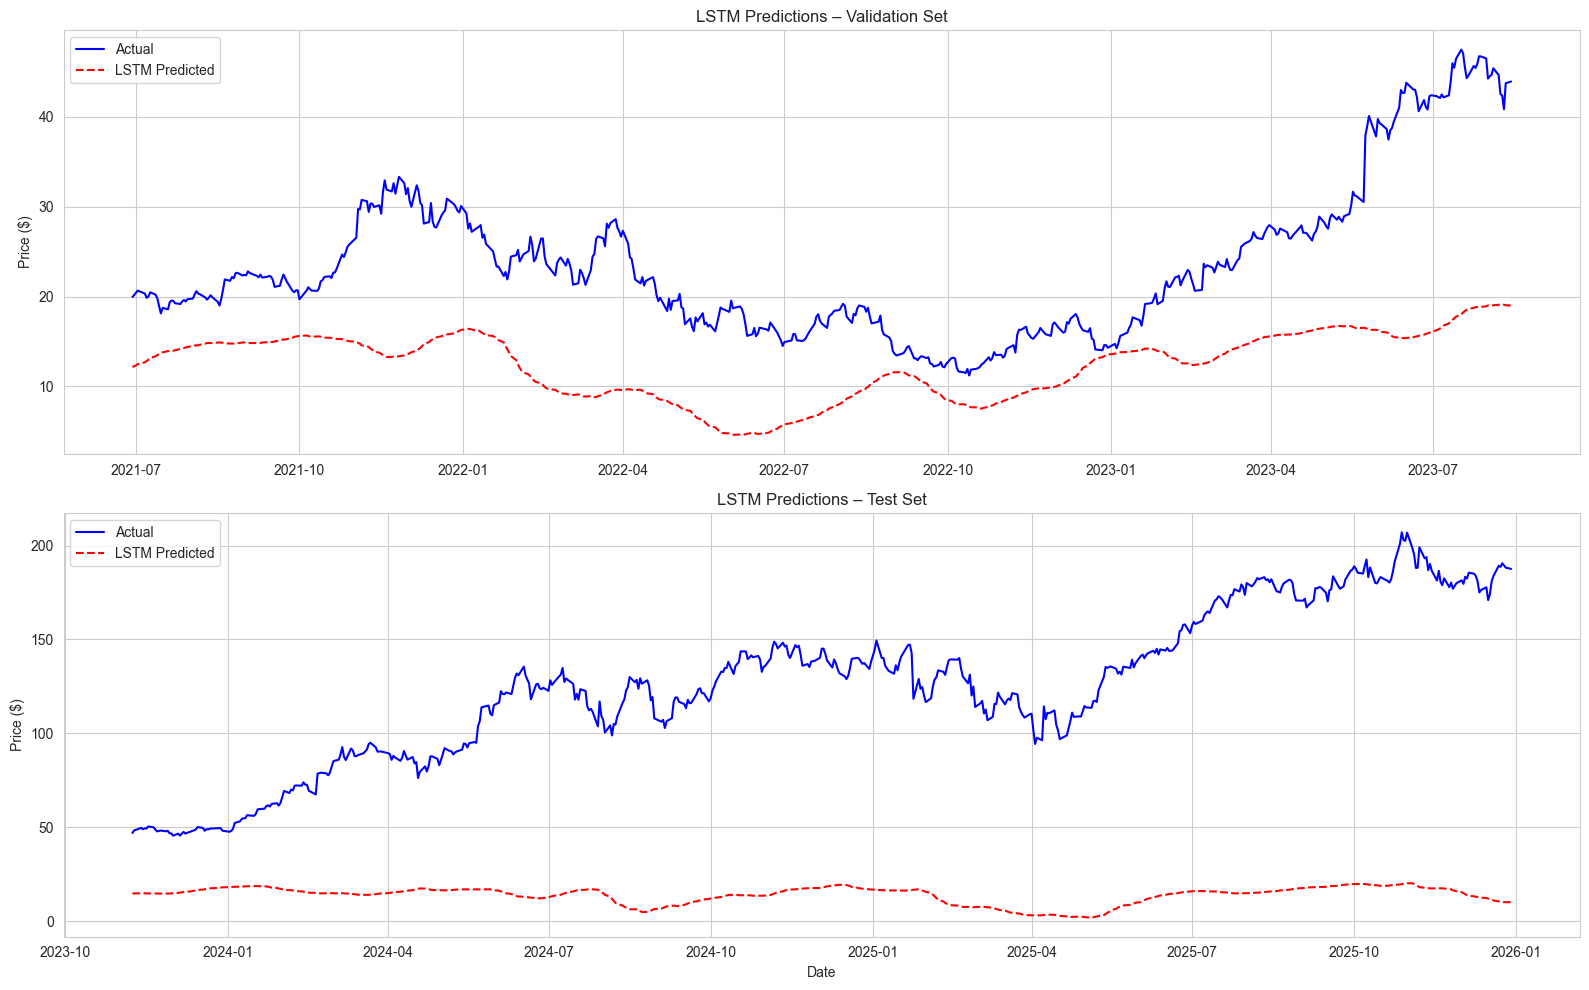

In [190]:
# Cell 56: Plot predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation
axes[0].plot(val_seq_dates, y_val_actual, label='Actual', color='blue')
axes[0].plot(val_seq_dates, y_val_pred, label='LSTM Predicted', color='red', linestyle='--')
axes[0].set_title('LSTM Predictions – Validation Set')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True)

# Test
axes[1].plot(test_seq_dates, y_test_actual, label='Actual', color='blue')
axes[1].plot(test_seq_dates, y_test_pred, label='LSTM Predicted', color='red', linestyle='--')
axes[1].set_title('LSTM Predictions – Test Set')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "lstm_predictions.png"))
plt.show()

In [191]:
# Cell 57: Compare with ARIMA baseline
# Load ARIMA test results and compute metrics
arima_results = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "arima_test_results.csv"))

# Compute ARIMA metrics from saved results
arima_test_rmse = np.sqrt(mean_squared_error(arima_results['actual'], arima_results['arima_pred']))
arima_test_mae = mean_absolute_error(arima_results['actual'], arima_results['arima_pred'])
arima_test_mape = np.mean(np.abs((arima_results['actual'] - arima_results['arima_pred']) / arima_results['actual'])) * 100
arima_dir_acc = arima_results['direction_pred'].iloc[:-1].eq(arima_results['direction_actual'].iloc[:-1]).mean() * 100

print("\n" + "="*70)
print("MODEL COMPARISON ON TEST SET")
print("="*70)
print(f"{'Model':<15} {'RMSE':<10} {'MAE':<10} {'MAPE(%)':<10} {'DirAcc(%)':<10}")
print("-"*70)
print(f"{'ARIMA':<15} {arima_test_rmse:<10.4f} {arima_test_mae:<10.4f} {arima_test_mape:<10.2f} {arima_dir_acc:<10.2f}")
print(f"{'LSTM':<15} {test_rmse:<10.4f} {test_mae:<10.4f} {test_mape:<10.2f} {test_dir_acc:<10.2f}")
print("="*70)

logger.info("Model comparison complete.")


MODEL COMPARISON ON TEST SET
Model           RMSE       MAE        MAPE(%)    DirAcc(%) 
----------------------------------------------------------------------
ARIMA           3.5968     2.5424     2.23       53.18     
LSTM            118.5634   111.4525   87.13      45.23     
2026-02-18 21:01:56,469 - INFO - Model comparison complete.


In [192]:
# Cell 58: Save LSTM predictions and metrics
lstm_results = pd.DataFrame({
    'date': test_seq_dates,
    'actual': y_test_actual,
    'lstm_pred': y_test_pred
})
lstm_results.to_csv(os.path.join(PROCESSED_DATA_PATH, "lstm_test_results.csv"), index=False)

# Save metrics
metrics_dict = {
    'model': 'LSTM',
    'val_rmse': val_rmse,
    'val_mae': val_mae,
    'val_mape': val_mape,
    'val_dir_acc': val_dir_acc,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_mape': test_mape,
    'test_dir_acc': test_dir_acc
}
metrics_df = pd.DataFrame([metrics_dict])
metrics_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "lstm_metrics.csv"), index=False)

logger.info("LSTM results saved.")

2026-02-18 21:01:56,499 - INFO - LSTM results saved.


In [193]:
# Cell 59: (Optional) Simple hyperparameter tuning
# We could run a quick grid search on a few key parameters, but given time we'll skip for now.
# If we wanted to, we'd use Keras Tuner or manual loops.
logger.info("Phase 5 complete. LSTM model trained and evaluated.")

2026-02-18 21:01:56,504 - INFO - Phase 5 complete. LSTM model trained and evaluated.


## GRU Model

In [194]:
# Cell 60: Import necessary libraries (if not already)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import pickle

logger.info("Starting Phase 6: GRU Model")

2026-02-18 21:01:56,511 - INFO - Starting Phase 6: GRU Model


In [195]:
# Cell 61: Load preprocessed sequences and targets
PROCESSED_DATA_PATH = "data/processed"

X_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_train_seq.npy"))
y_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_train_seq.npy"))
X_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_val_seq.npy"))
y_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_val_seq.npy"))
X_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_test_seq.npy"))
y_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_test_seq.npy"))

train_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "train_seq_dates.npy"), allow_pickle=True)
val_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "val_seq_dates.npy"), allow_pickle=True)
test_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "test_seq_dates.npy"), allow_pickle=True)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")

X_train_seq shape: (2717, 60, 29)
y_train_seq shape: (2717,)
X_val_seq shape: (535, 60, 29)
X_test_seq shape: (536, 60, 29)


In [196]:
# Cell 62: Load target scaler (fitted on training targets in Phase 5)
target_scaler = joblib.load(os.path.join(PROCESSED_DATA_PATH, "target_scaler.pkl"))

# Scale targets (use same scaler for consistency)
y_train_scaled = target_scaler.transform(y_train_seq.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val_seq.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test_seq.reshape(-1, 1)).flatten()

In [197]:
# Cell 63: Define GRU model architecture
def build_gru_model(input_shape, gru_units=[64, 32], dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # First GRU layer with return sequences for stacking
    model.add(GRU(units=gru_units[0], return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    # Second GRU layer
    model.add(GRU(units=gru_units[1], return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Dense layers
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    model.add(Dense(1))  # Linear activation for regression
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Model parameters (can be tuned)
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
gru_units = [64, 32]
dropout_rate = 0.3
learning_rate = 0.001

model = build_gru_model(input_shape, gru_units, dropout_rate, learning_rate)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 64)         │        18,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,499 (111.32 KB)

 Trainable params: 28,499 (111.32 KB)

 Non-trainable params: 0 (0.00 B)

In [198]:
# Cell 64: Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join("models", "gru_best.keras"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

logger.info("Callbacks configured.")

2026-02-18 21:01:56,685 - INFO - Callbacks configured.


In [199]:
# Cell 65: Train the GRU model
history = model.fit(
    X_train_seq, y_train_scaled,
    validation_data=(X_val_seq, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Save training history
with open(os.path.join("models", "gru_history.pkl"), 'wb') as f:
    pickle.dump(history.history, f)

logger.info("GRU training completed.")

Epoch 1/100
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0594 - mae: 0.1725
Epoch 1: val_loss improved from None to 0.93865, saving model to models\gru_best.keras

Epoch 1: finished saving model to models\gru_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0362 - mae: 0.1261 - val_loss: 0.9386 - val_mae: 0.8501 - learning_rate: 0.0010
Epoch 2/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0144 - mae: 0.0741
Epoch 2: val_loss improved from 0.93865 to 0.87686, saving model to models\gru_best.keras

Epoch 2: finished saving model to models\gru_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0131 - mae: 0.0706 - val_loss: 0.8769 - val_mae: 0.8314 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0117 - mae: 0.0676
Epoch 3: val_loss improved from 0.87686 to 0.71970, saving model to models\gru_best.keras

Epoch 3: finished saving model to models\gru_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0109 - ma

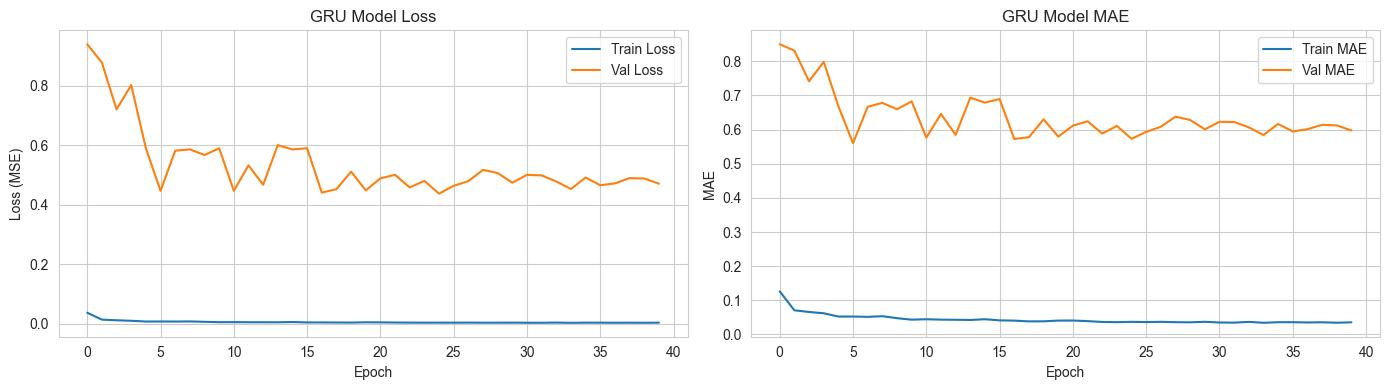

In [200]:
# Cell 66: Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('GRU Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('GRU Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "gru_training_history.png"))
plt.show()

In [201]:
# Cell 67: Load the best GRU model
best_model = load_model(os.path.join("models", "gru_best.keras"))
logger.info("Best GRU model loaded.")

2026-02-18 21:03:36,106 - INFO - Best GRU model loaded.


In [202]:
# Cell 68: Evaluate on validation and test sets
# Validation predictions
y_val_pred_scaled = best_model.predict(X_val_seq, verbose=0)
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled).flatten()
y_val_actual = y_val_seq

# Test predictions
y_test_pred_scaled = best_model.predict(X_test_seq, verbose=0)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled).flatten()
y_test_actual = y_test_seq

# Compute metrics

val_rmse, val_mae, val_mape, val_dir_acc = compute_metrics(y_val_actual, y_val_pred)
test_rmse, test_mae, test_mape, test_dir_acc = compute_metrics(y_test_actual, y_test_pred)

print("\nGRU Validation Set Performance:")
print(f"RMSE: {val_rmse:.4f}   MAE: {val_mae:.4f}   MAPE: {val_mape:.2f}%   DirAcc: {val_dir_acc:.2f}%")

print("\nGRU Test Set Performance:")
print(f"RMSE: {test_rmse:.4f}   MAE: {test_mae:.4f}   MAPE: {test_mape:.2f}%   DirAcc: {test_dir_acc:.2f}%")


GRU Validation Set Performance:
RMSE: 9.9663   MAE: 8.6444   MAPE: 36.71%   DirAcc: 48.50%

GRU Test Set Performance:
RMSE: 104.9684   MAE: 97.8381   MAPE: 75.95%   DirAcc: 45.23%


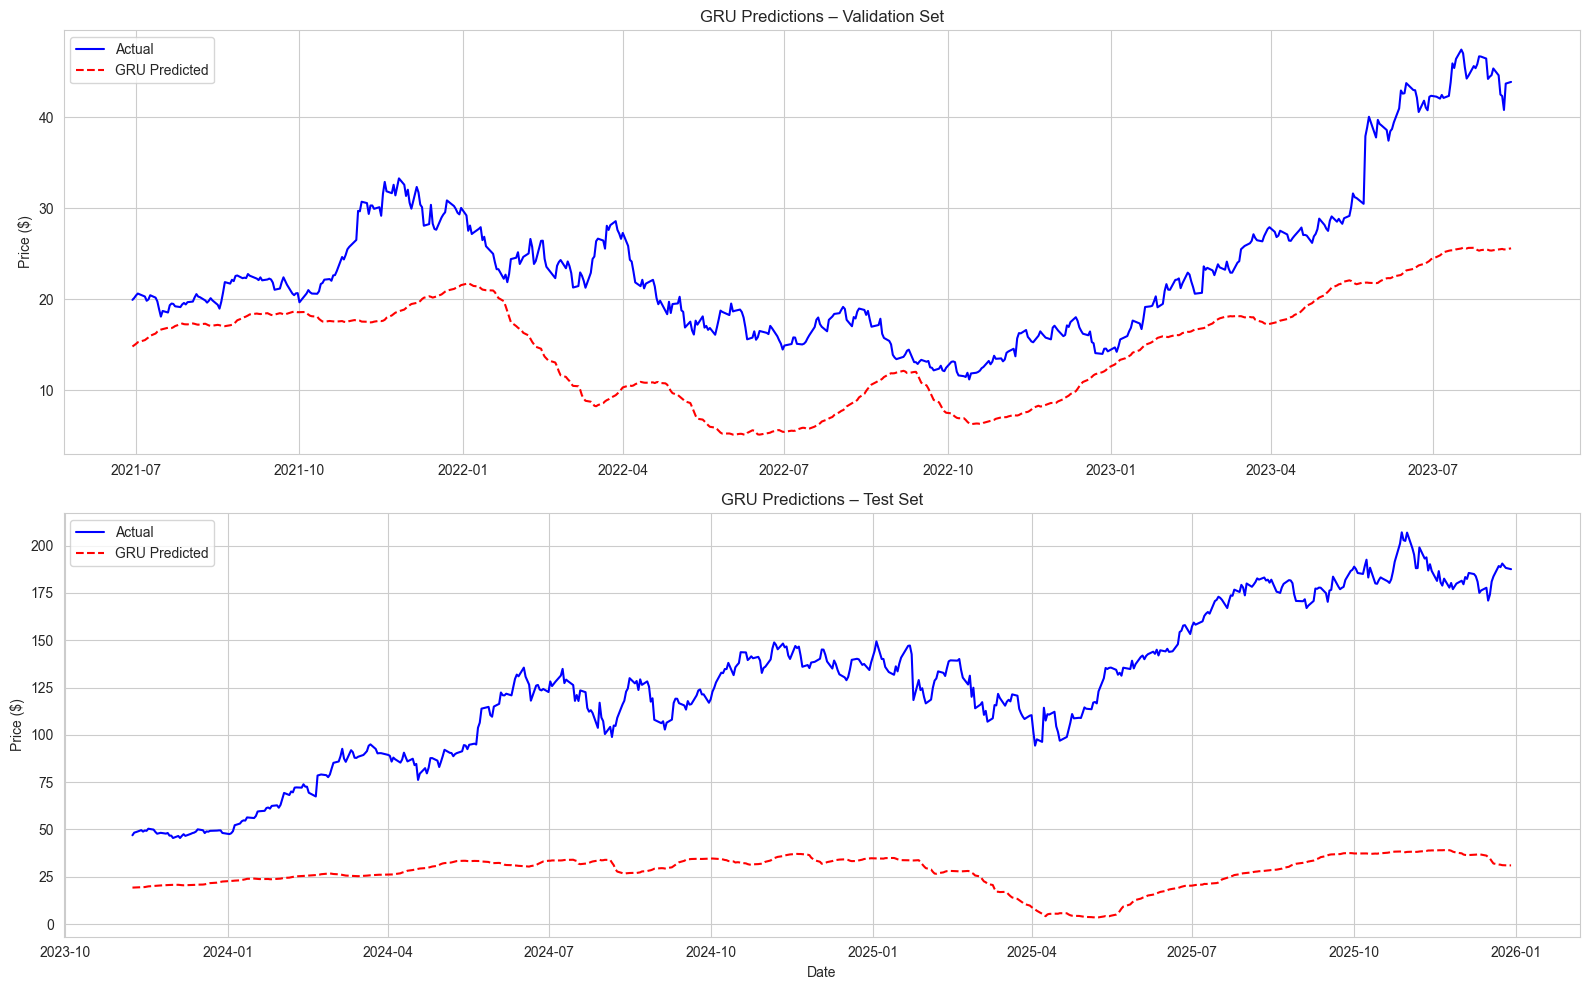

In [203]:
# Cell 69: Plot GRU predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation
axes[0].plot(val_seq_dates, y_val_actual, label='Actual', color='blue')
axes[0].plot(val_seq_dates, y_val_pred, label='GRU Predicted', color='red', linestyle='--')
axes[0].set_title('GRU Predictions – Validation Set')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True)

# Test
axes[1].plot(test_seq_dates, y_test_actual, label='Actual', color='blue')
axes[1].plot(test_seq_dates, y_test_pred, label='GRU Predicted', color='red', linestyle='--')
axes[1].set_title('GRU Predictions – Test Set')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "gru_predictions.png"))
plt.show()

In [204]:
# Cell 70: Compare with ARIMA and LSTM
# Load ARIMA test results
arima_results = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "arima_test_results.csv"))
arima_test_rmse = np.sqrt(mean_squared_error(arima_results['actual'], arima_results['arima_pred']))
arima_test_mae = mean_absolute_error(arima_results['actual'], arima_results['arima_pred'])
arima_test_mape = np.mean(np.abs((arima_results['actual'] - arima_results['arima_pred']) / arima_results['actual'])) * 100
arima_dir_acc = arima_results['direction_pred'].iloc[:-1].eq(arima_results['direction_actual'].iloc[:-1]).mean() * 100

# Load LSTM metrics
lstm_metrics = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "lstm_metrics.csv"))
lstm_test_rmse = lstm_metrics['test_rmse'].values[0]
lstm_test_mae = lstm_metrics['test_mae'].values[0]
lstm_test_mape = lstm_metrics['test_mape'].values[0]
lstm_test_dir_acc = lstm_metrics['test_dir_acc'].values[0]

print("\n" + "="*80)
print("MODEL COMPARISON ON TEST SET")
print("="*80)
print(f"{'Model':<15} {'RMSE':<12} {'MAE':<12} {'MAPE(%)':<12} {'DirAcc(%)':<12}")
print("-"*80)
print(f"{'ARIMA':<15} {arima_test_rmse:<12.4f} {arima_test_mae:<12.4f} {arima_test_mape:<12.2f} {arima_dir_acc:<12.2f}")
print(f"{'LSTM':<15} {lstm_test_rmse:<12.4f} {lstm_test_mae:<12.4f} {lstm_test_mape:<12.2f} {lstm_test_dir_acc:<12.2f}")
print(f"{'GRU':<15} {test_rmse:<12.4f} {test_mae:<12.4f} {test_mape:<12.2f} {test_dir_acc:<12.2f}")
print("="*80)


MODEL COMPARISON ON TEST SET
Model           RMSE         MAE          MAPE(%)      DirAcc(%)   
--------------------------------------------------------------------------------
ARIMA           3.5968       2.5424       2.23         53.18       
LSTM            118.5634     111.4525     87.13        45.23       
GRU             104.9684     97.8381      75.95        45.23       


In [205]:
# Cell 71: Save GRU predictions and metrics
gru_results = pd.DataFrame({
    'date': test_seq_dates,
    'actual': y_test_actual,
    'gru_pred': y_test_pred
})
gru_results.to_csv(os.path.join(PROCESSED_DATA_PATH, "gru_test_results.csv"), index=False)

# Save metrics
gru_metrics_dict = {
    'model': 'GRU',
    'val_rmse': val_rmse,
    'val_mae': val_mae,
    'val_mape': val_mape,
    'val_dir_acc': val_dir_acc,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_mape': test_mape,
    'test_dir_acc': test_dir_acc
}
gru_metrics_df = pd.DataFrame([gru_metrics_dict])
gru_metrics_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "gru_metrics.csv"), index=False)

logger.info("GRU results saved.")

2026-02-18 21:03:37,530 - INFO - GRU results saved.


In [206]:
# Cell 72: (Optional) Quick analysis of GRU vs LSTM
improvement_rmse = (lstm_test_rmse - test_rmse) / lstm_test_rmse * 100
improvement_dir = (test_dir_acc - lstm_test_dir_acc)

print("\nGRU vs LSTM on Test Set:")
print(f"RMSE improvement: {improvement_rmse:+.2f}% (negative means GRU better)")
print(f"Directional accuracy change: {improvement_dir:+.2f} percentage points")

logger.info("Phase 6 complete. GRU model trained and evaluated.")


GRU vs LSTM on Test Set:
RMSE improvement: +11.47% (negative means GRU better)
Directional accuracy change: +0.00 percentage points
2026-02-18 21:03:37,539 - INFO - Phase 6 complete. GRU model trained and evaluated.


## CNN-BiGRU Hybrid Model

In [207]:
# Cell 73: Import necessary libraries (if not already)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU, Dense, Dropout, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import pickle

logger.info("Starting Phase 7: CNN-BiGRU Hybrid Model")

2026-02-18 21:03:37,550 - INFO - Starting Phase 7: CNN-BiGRU Hybrid Model


In [208]:
# Cell 74: Load preprocessed sequences and targets
PROCESSED_DATA_PATH = "data/processed"

X_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_train_seq.npy"))
y_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_train_seq.npy"))
X_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_val_seq.npy"))
y_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_val_seq.npy"))
X_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_test_seq.npy"))
y_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_test_seq.npy"))

train_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "train_seq_dates.npy"), allow_pickle=True)
val_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "val_seq_dates.npy"), allow_pickle=True)
test_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "test_seq_dates.npy"), allow_pickle=True)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")

X_train_seq shape: (2717, 60, 29)
y_train_seq shape: (2717,)
X_val_seq shape: (535, 60, 29)
X_test_seq shape: (536, 60, 29)


In [209]:
# Cell 75: Load target scaler and scale targets
target_scaler = joblib.load(os.path.join(PROCESSED_DATA_PATH, "target_scaler.pkl"))

y_train_scaled = target_scaler.transform(y_train_seq.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val_seq.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test_seq.reshape(-1, 1)).flatten()

In [210]:
# Cell 76: Define CNN-BiGRU model architecture
def build_cnn_bigru_model(input_shape, 
                          conv_filters=64, 
                          kernel_size=3, 
                          pool_size=2, 
                          gru_units=50, 
                          dropout_rate=0.3, 
                          learning_rate=0.001):
    """
    Build a hybrid CNN-Bidirectional GRU model.
    
    Args:
        input_shape: (window_size, n_features)
        conv_filters: number of filters in Conv1D
        kernel_size: size of convolutional kernel
        pool_size: pooling window size
        gru_units: number of GRU units in each direction
        dropout_rate: dropout rate after each layer
        learning_rate: Adam learning rate
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # 1D Convolutional layer for feature extraction
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout_rate))
    
    # Bidirectional GRU layer
    model.add(Bidirectional(GRU(units=gru_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    
    # Dense layers
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    model.add(Dense(1))  # Linear activation for regression
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Model parameters (can be tuned)
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
conv_filters = 64
kernel_size = 3
pool_size = 2
gru_units = 50
dropout_rate = 0.3
learning_rate = 0.001

model = build_cnn_bigru_model(input_shape, conv_filters, kernel_size, pool_size, gru_units, dropout_rate, learning_rate)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 60, 64)         │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        34,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,983 (167.90 KB)

 Trainable params: 42,983 (167.90 KB)

 Non-trainable params: 0 (0.00 B)

In [211]:
# Cell 77: Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join("models", "cnn_bigru_best.keras"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

logger.info("Callbacks configured.")

2026-02-18 21:03:37,704 - INFO - Callbacks configured.


In [212]:
# Cell 78: Train the CNN-BiGRU model
history = model.fit(
    X_train_seq, y_train_scaled,
    validation_data=(X_val_seq, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Save training history
with open(os.path.join("models", "cnn_bigru_history.pkl"), 'wb') as f:
    pickle.dump(history.history, f)

logger.info("CNN-BiGRU training completed.")

Epoch 1/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0745 - mae: 0.1958
Epoch 1: val_loss improved from None to 0.86622, saving model to models\cnn_bigru_best.keras

Epoch 1: finished saving model to models\cnn_bigru_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0421 - mae: 0.1408 - val_loss: 0.8662 - val_mae: 0.8385 - learning_rate: 0.0010
Epoch 2/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0119 - mae: 0.0690
Epoch 2: val_loss improved from 0.86622 to 0.70263, saving model to models\cnn_bigru_best.keras

Epoch 2: finished saving model to models\cnn_bigru_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0115 - mae: 0.0677 - val_loss: 0.7026 - val_mae: 0.7525 - learning_rate: 0.0010
Epoch 3/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0077 - mae: 0.0538
Epoch 3: val_loss improved from 0.70263 to 0.66673, saving model to models\cnn_bigru_best.keras

Epoch 3: finished saving model to models\cnn_bigru_best.keras
85/85 ━━━━━━━━━━━━━━━━━

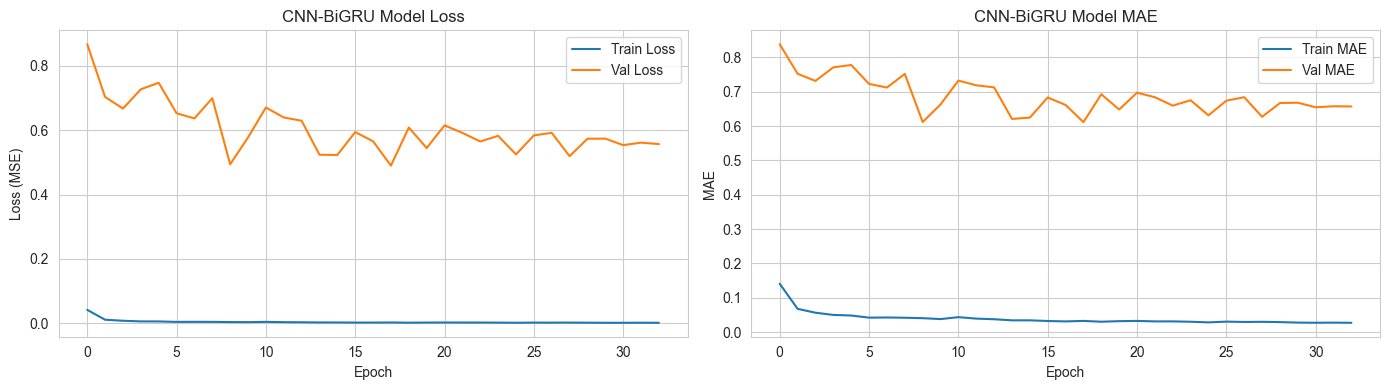

In [213]:
# Cell 79: Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('CNN-BiGRU Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('CNN-BiGRU Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "cnn_bigru_training_history.png"))
plt.show()

In [214]:
# Cell 80: Load the best CNN-BiGRU model
best_model = load_model(os.path.join("models", "cnn_bigru_best.keras"))
logger.info("Best CNN-BiGRU model loaded.")

2026-02-18 21:04:17,360 - INFO - Best CNN-BiGRU model loaded.


In [215]:
# Cell 81: Evaluate on validation and test sets
# Validation predictions
y_val_pred_scaled = best_model.predict(X_val_seq, verbose=0)
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled).flatten()
y_val_actual = y_val_seq

# Test predictions
y_test_pred_scaled = best_model.predict(X_test_seq, verbose=0)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled).flatten()
y_test_actual = y_test_seq

# Compute metrics

val_rmse, val_mae, val_mape, val_dir_acc = compute_metrics(y_val_actual, y_val_pred)
test_rmse, test_mae, test_mape, test_dir_acc = compute_metrics(y_test_actual, y_test_pred)

print("\nCNN-BiGRU Validation Set Performance:")
print(f"RMSE: {val_rmse:.4f}   MAE: {val_mae:.4f}   MAPE: {val_mape:.2f}%   DirAcc: {val_dir_acc:.2f}%")

print("\nCNN-BiGRU Test Set Performance:")
print(f"RMSE: {test_rmse:.4f}   MAE: {test_mae:.4f}   MAPE: {test_mape:.2f}%   DirAcc: {test_dir_acc:.2f}%")


CNN-BiGRU Validation Set Performance:
RMSE: 10.5552   MAE: 9.2254   MAPE: 38.26%   DirAcc: 48.50%

CNN-BiGRU Test Set Performance:
RMSE: 108.6666   MAE: 101.6022   MAPE: 79.17%   DirAcc: 45.23%


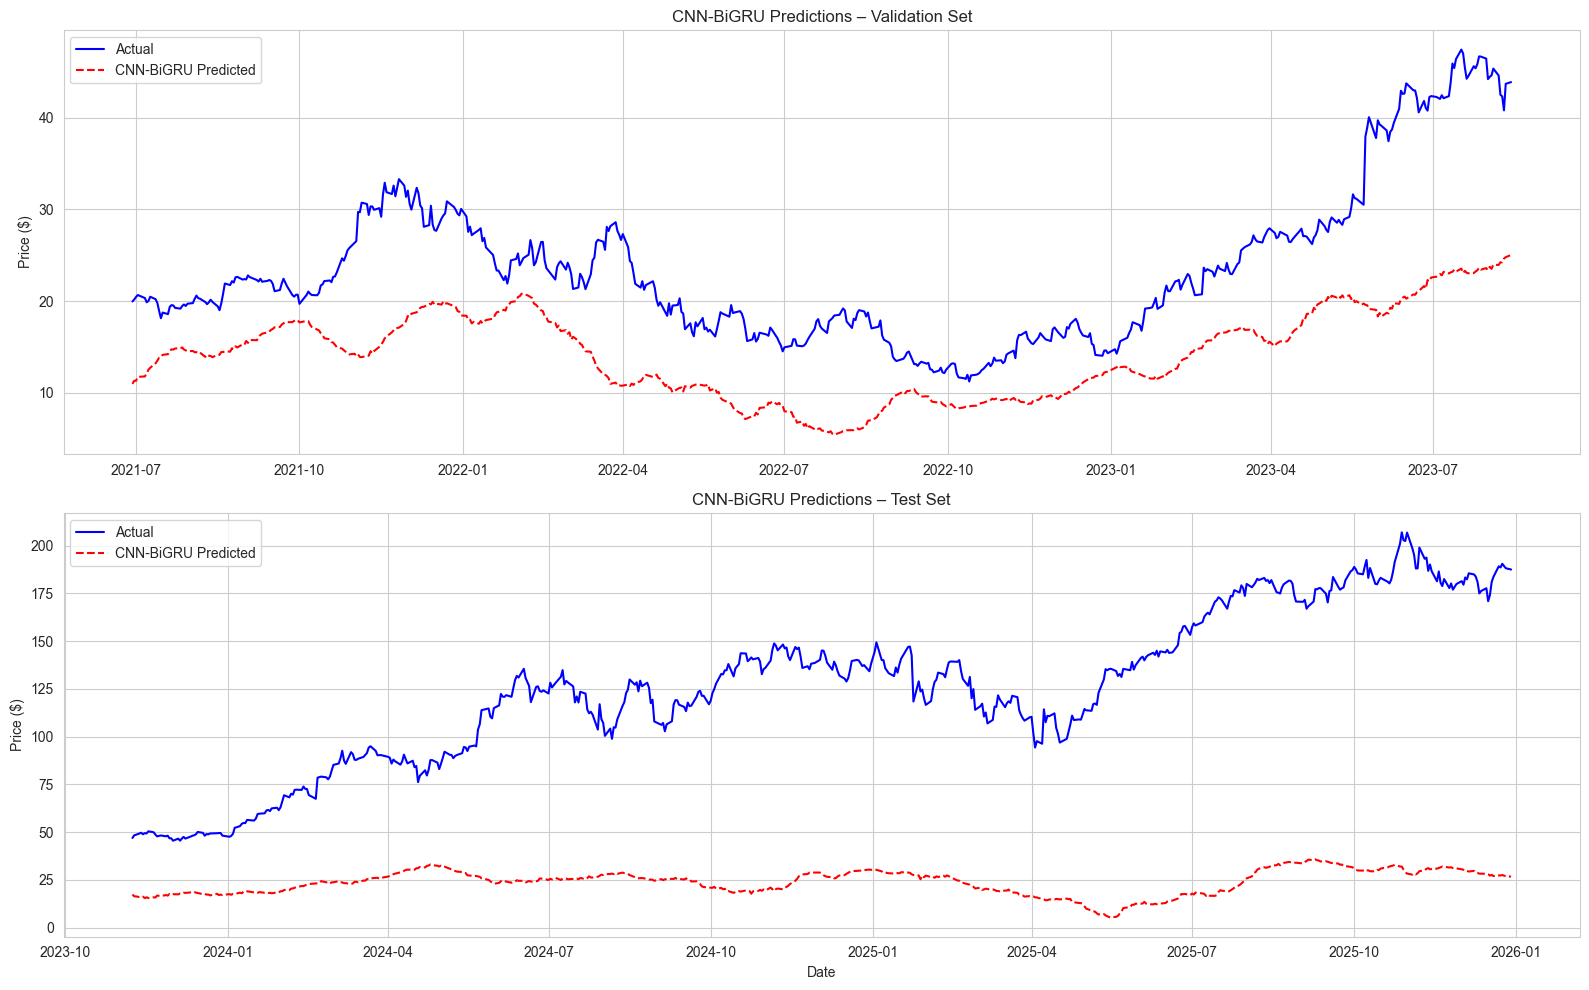

In [216]:
# Cell 82: Plot CNN-BiGRU predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation
axes[0].plot(val_seq_dates, y_val_actual, label='Actual', color='blue')
axes[0].plot(val_seq_dates, y_val_pred, label='CNN-BiGRU Predicted', color='red', linestyle='--')
axes[0].set_title('CNN-BiGRU Predictions – Validation Set')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True)

# Test
axes[1].plot(test_seq_dates, y_test_actual, label='Actual', color='blue')
axes[1].plot(test_seq_dates, y_test_pred, label='CNN-BiGRU Predicted', color='red', linestyle='--')
axes[1].set_title('CNN-BiGRU Predictions – Test Set')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "cnn_bigru_predictions.png"))
plt.show()

In [217]:
# Cell 83: Compare with previous models
# Load previous metrics
arima_results = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "arima_test_results.csv"))
arima_test_rmse = np.sqrt(mean_squared_error(arima_results['actual'], arima_results['arima_pred']))
arima_test_mae = mean_absolute_error(arima_results['actual'], arima_results['arima_pred'])
arima_test_mape = np.mean(np.abs((arima_results['actual'] - arima_results['arima_pred']) / arima_results['actual'])) * 100
arima_dir_acc = arima_results['direction_pred'].iloc[:-1].eq(arima_results['direction_actual'].iloc[:-1]).mean() * 100

lstm_metrics = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "lstm_metrics.csv"))
lstm_test_rmse = lstm_metrics['test_rmse'].values[0]
lstm_test_mae = lstm_metrics['test_mae'].values[0]
lstm_test_mape = lstm_metrics['test_mape'].values[0]
lstm_test_dir_acc = lstm_metrics['test_dir_acc'].values[0]

gru_metrics = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "gru_metrics.csv"))
gru_test_rmse = gru_metrics['test_rmse'].values[0]
gru_test_mae = gru_metrics['test_mae'].values[0]
gru_test_mape = gru_metrics['test_mape'].values[0]
gru_test_dir_acc = gru_metrics['test_dir_acc'].values[0]

print("\n" + "="*90)
print("MODEL COMPARISON ON TEST SET")
print("="*90)
print(f"{'Model':<18} {'RMSE':<12} {'MAE':<12} {'MAPE(%)':<12} {'DirAcc(%)':<12}")
print("-"*90)
print(f"{'ARIMA':<18} {arima_test_rmse:<12.4f} {arima_test_mae:<12.4f} {arima_test_mape:<12.2f} {arima_dir_acc:<12.2f}")
print(f"{'LSTM':<18} {lstm_test_rmse:<12.4f} {lstm_test_mae:<12.4f} {lstm_test_mape:<12.2f} {lstm_test_dir_acc:<12.2f}")
print(f"{'GRU':<18} {gru_test_rmse:<12.4f} {gru_test_mae:<12.4f} {gru_test_mape:<12.2f} {gru_test_dir_acc:<12.2f}")
print(f"{'CNN-BiGRU':<18} {test_rmse:<12.4f} {test_mae:<12.4f} {test_mape:<12.2f} {test_dir_acc:<12.2f}")
print("="*90)


MODEL COMPARISON ON TEST SET
Model              RMSE         MAE          MAPE(%)      DirAcc(%)   
------------------------------------------------------------------------------------------
ARIMA              3.5968       2.5424       2.23         53.18       
LSTM               118.5634     111.4525     87.13        45.23       
GRU                104.9684     97.8381      75.95        45.23       
CNN-BiGRU          108.6666     101.6022     79.17        45.23       


In [218]:
# Cell 84: Save CNN-BiGRU predictions and metrics
cnn_bigru_results = pd.DataFrame({
    'date': test_seq_dates,
    'actual': y_test_actual,
    'cnn_bigru_pred': y_test_pred
})
cnn_bigru_results.to_csv(os.path.join(PROCESSED_DATA_PATH, "cnn_bigru_test_results.csv"), index=False)

# Save metrics
cnn_bigru_metrics_dict = {
    'model': 'CNN-BiGRU',
    'val_rmse': val_rmse,
    'val_mae': val_mae,
    'val_mape': val_mape,
    'val_dir_acc': val_dir_acc,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_mape': test_mape,
    'test_dir_acc': test_dir_acc
}
cnn_bigru_metrics_df = pd.DataFrame([cnn_bigru_metrics_dict])
cnn_bigru_metrics_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "cnn_bigru_metrics.csv"), index=False)

logger.info("CNN-BiGRU results saved.")

2026-02-18 21:04:18,832 - INFO - CNN-BiGRU results saved.


In [219]:
# Cell 85: (Optional) Analyze feature importance via integrated gradients or permutation importance
# This is a more advanced step, could be added later.

logger.info("Phase 7 complete. CNN-BiGRU hybrid model trained and evaluated.")

2026-02-18 21:04:18,838 - INFO - Phase 7 complete. CNN-BiGRU hybrid model trained and evaluated.


## Transformer for Time Series

In [220]:
# Cell 86: Import necessary libraries (if not already)
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, LayerNormalization, 
                                     MultiHeadAttention, GlobalAveragePooling1D, 
                                     Add, Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
import pickle

logger.info("Starting Phase 8: Transformer Model")

2026-02-18 21:04:18,845 - INFO - Starting Phase 8: Transformer Model


In [221]:
# Cell 87: Load preprocessed sequences and targets
PROCESSED_DATA_PATH = "data/processed"

X_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_train_seq.npy"))
y_train_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_train_seq.npy"))
X_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_val_seq.npy"))
y_val_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_val_seq.npy"))
X_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "X_test_seq.npy"))
y_test_seq = np.load(os.path.join(PROCESSED_DATA_PATH, "y_test_seq.npy"))

train_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "train_seq_dates.npy"), allow_pickle=True)
val_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "val_seq_dates.npy"), allow_pickle=True)
test_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "test_seq_dates.npy"), allow_pickle=True)

print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")

X_train_seq shape: (2717, 60, 29)
y_train_seq shape: (2717,)
X_val_seq shape: (535, 60, 29)
X_test_seq shape: (536, 60, 29)


In [222]:
# Cell 88: Load target scaler and scale targets
target_scaler = joblib.load(os.path.join(PROCESSED_DATA_PATH, "target_scaler.pkl"))

y_train_scaled = target_scaler.transform(y_train_seq.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val_seq.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test_seq.reshape(-1, 1)).flatten()

In [224]:
# Cell 89: Define Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    """
    A single transformer encoder block.
    
    Args:
        inputs: Input tensor
        head_size: Dimension of each attention head
        num_heads: Number of attention heads
        ff_dim: Hidden layer size in feed-forward network
        dropout: Dropout rate
    """
    # Multi-head self-attention
    attention = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)  # Add & Norm
    
    # Feed-forward network
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1])(ff)  # Project back to original dimension
    ff = Dropout(dropout)(ff)
    outputs = LayerNormalization(epsilon=1e-6)(attention + ff)  # Add & Norm
    
    return outputs

@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Learnable positional embedding layer for Transformer.
    This is implemented as a custom layer for proper serialization.
    """
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=sequence_length, 
            output_dim=output_dim
        )
    
    def call(self, inputs):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        pos_emb = self.position_embedding(positions)
        return inputs + pos_emb
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "output_dim": self.output_dim,
        })
        return config

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_layers=2, dropout=0.1, learning_rate=0.001):
    """
    Build a Transformer encoder for time series regression with positional encoding.
    
    Args:
        input_shape: (sequence_length, n_features)
        head_size: Dimension of each attention head
        num_heads: Number of attention heads
        ff_dim: Hidden layer size in feed-forward network
        num_layers: Number of transformer encoder blocks
        dropout: Dropout rate
        learning_rate: Adam learning rate
    """
    inputs = Input(shape=input_shape)
    
    # Add positional encoding using custom layer for proper serialization
    x = PositionalEmbedding(sequence_length=input_shape[0], output_dim=input_shape[1])(inputs)
    
    # Stack transformer encoder blocks
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global pooling to get a fixed-size output
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    
    # Final regression head
    x = Dense(50, activation="relu")(x)
    x = Dropout(dropout/2)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Model parameters (can be tuned)
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
head_size = 64
num_heads = 4
ff_dim = 128
num_layers = 2
dropout = 0.1
learning_rate = 0.001

model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout, learning_rate)
model.summary()

Model: "functional_89"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 60, 29)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 60, 29)    │      1,740 │ input_layer_7[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 29)    │     30,493 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 60, 29)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 60, 29)    │          0 │ positional_embed… │
│                     │                   │            │ dropout_31[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 29)    │         58 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 60, 128)   │      3,840 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 60, 128)   │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 60, 29)    │      3,741 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 60, 29)    │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 60, 29)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 29)    │         58 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 29)    │     30,493 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 60, 29)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 60, 29)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 29)    │         58 │ add_6[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 60, 128)   │      3,840 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 60, 128)   │          0 │ dense_20[0][0]  

 Total params: 79,671 (311.21 KB)

 Trainable params: 79,671 (311.21 KB)

 Non-trainable params: 0 (0.00 B)

In [225]:
# Cell 90: Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath=os.path.join("models", "transformer_best.keras"),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

logger.info("Callbacks configured.")

2026-02-18 21:06:20,767 - INFO - Callbacks configured.


In [226]:
# Cell 91: Train the Transformer model
history = model.fit(
    X_train_seq, y_train_scaled,
    validation_data=(X_val_seq, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Save training history
with open(os.path.join("models", "transformer_history.pkl"), 'wb') as f:
    pickle.dump(history.history, f)

logger.info("Transformer training completed.")

Epoch 1/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1357 - mae: 0.2567
Epoch 1: val_loss improved from None to 0.84333, saving model to models\transformer_best.keras

Epoch 1: finished saving model to models\transformer_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.0591 - mae: 0.1659 - val_loss: 0.8433 - val_mae: 0.8349 - learning_rate: 0.0010
Epoch 2/100
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0121 - mae: 0.0817
Epoch 2: val_loss improved from 0.84333 to 0.66327, saving model to models\transformer_best.keras

Epoch 2: finished saving model to models\transformer_best.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0107 - mae: 0.0762 - val_loss: 0.6633 - val_mae: 0.7221 - learning_rate: 0.0010
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0087 - mae: 0.0687
Epoch 3: val_loss improved from 0.66327 to 0.56015, saving model to models\transformer_best.keras

Epoch 3: finished saving model to models\transformer_best.keras
85/85 ━━━━

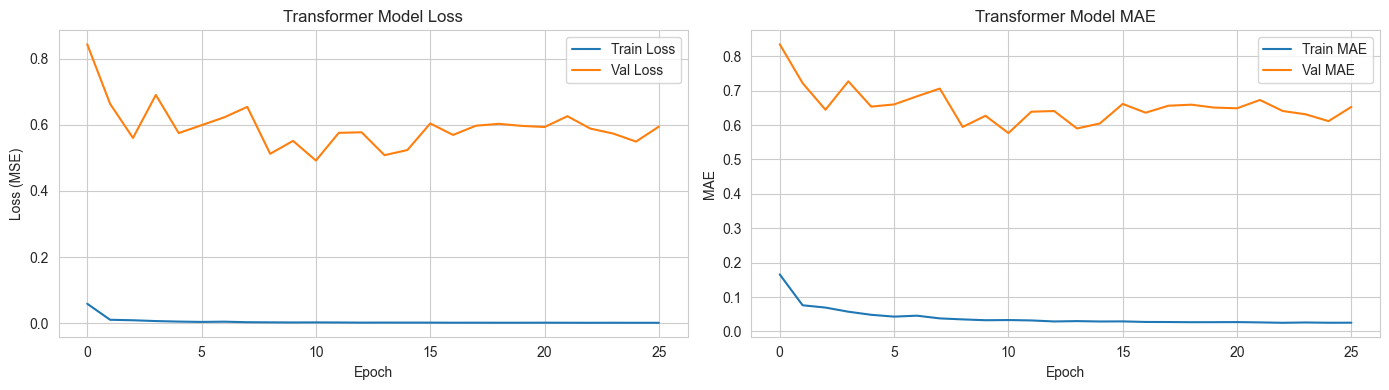

In [227]:
# Cell 92: Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Transformer Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('Transformer Model MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "transformer_training_history.png"))
plt.show()

In [228]:
# Cell 93: Load the best Transformer model
best_model = load_model(
    os.path.join("models", "transformer_best.keras"),
    custom_objects={"PositionalEmbedding": PositionalEmbedding}
)
logger.info("Best Transformer model loaded.")


2026-02-18 21:08:18,182 - INFO - Best Transformer model loaded.


In [229]:
# Cell 94: Evaluate on validation and test sets
# Validation predictions
y_val_pred_scaled = best_model.predict(X_val_seq, verbose=0)
y_val_pred = target_scaler.inverse_transform(y_val_pred_scaled).flatten()
y_val_actual = y_val_seq

# Test predictions
y_test_pred_scaled = best_model.predict(X_test_seq, verbose=0)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled).flatten()
y_test_actual = y_test_seq

# Compute metrics

val_rmse, val_mae, val_mape, val_dir_acc = compute_metrics(y_val_actual, y_val_pred)
test_rmse, test_mae, test_mape, test_dir_acc = compute_metrics(y_test_actual, y_test_pred)

print("\nTransformer Validation Set Performance:")
print(f"RMSE: {val_rmse:.4f}   MAE: {val_mae:.4f}   MAPE: {val_mape:.2f}%   DirAcc: {val_dir_acc:.2f}%")

print("\nTransformer Test Set Performance:")
print(f"RMSE: {test_rmse:.4f}   MAE: {test_mae:.4f}   MAPE: {test_mape:.2f}%   DirAcc: {test_dir_acc:.2f}%")


Transformer Validation Set Performance:
RMSE: 10.5792   MAE: 8.6994   MAPE: 34.12%   DirAcc: 48.88%

Transformer Test Set Performance:
RMSE: 115.8142   MAE: 108.3246   MAPE: 84.24%   DirAcc: 45.23%


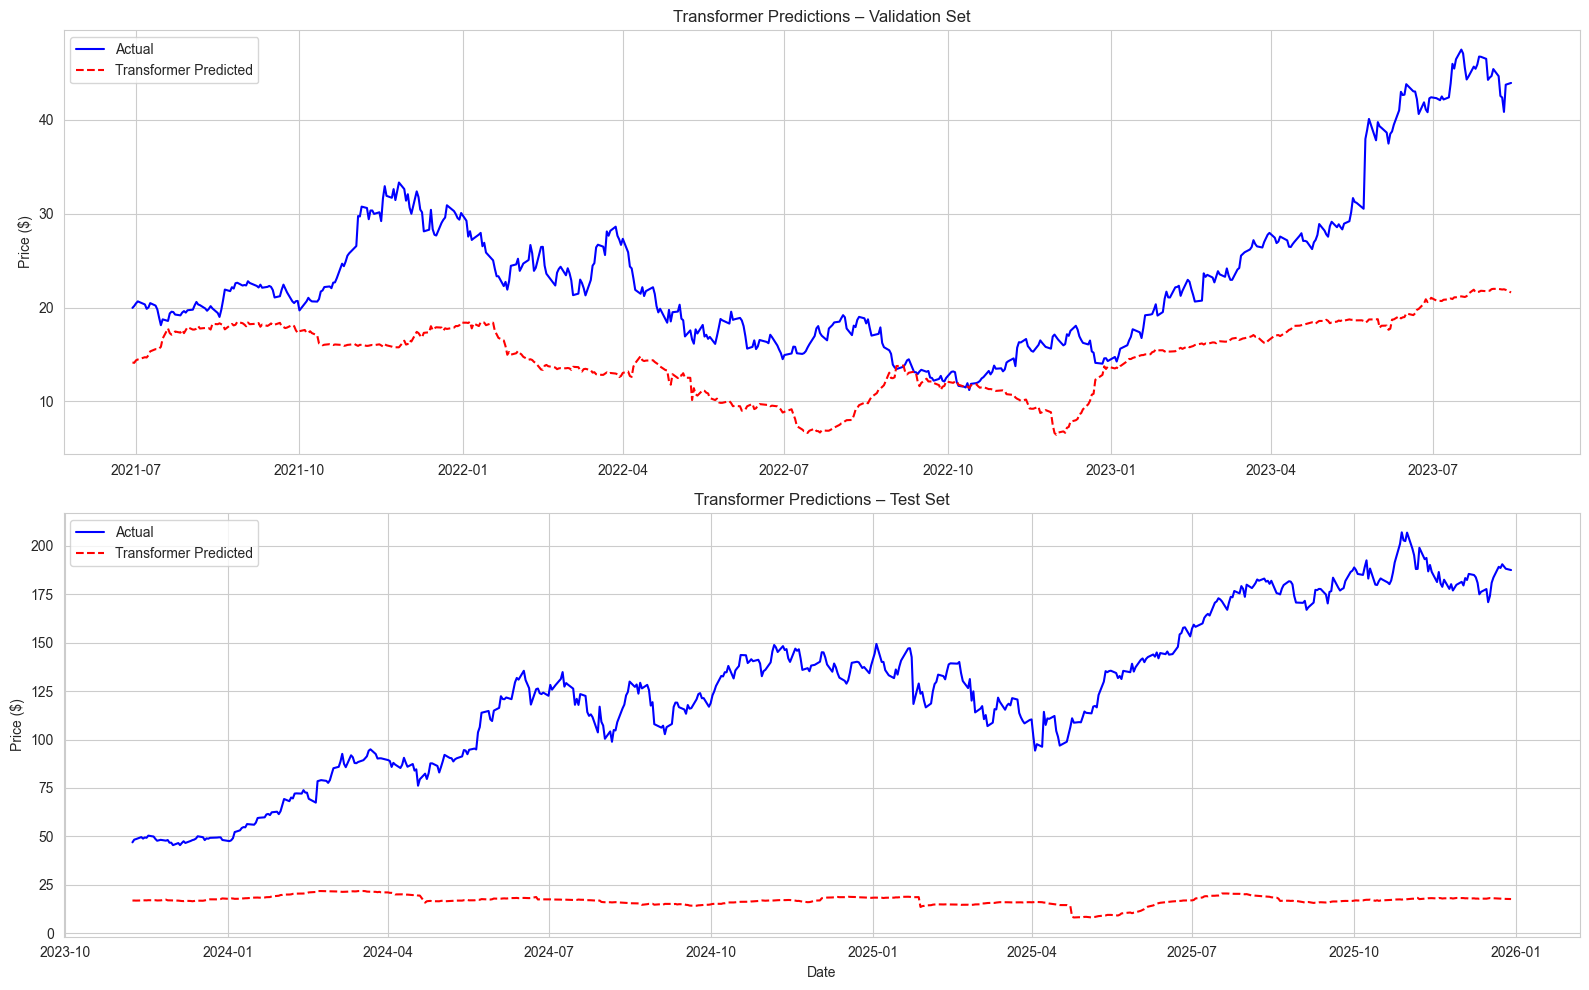

In [230]:
# Cell 95: Plot Transformer predictions vs actual
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Validation
axes[0].plot(val_seq_dates, y_val_actual, label='Actual', color='blue')
axes[0].plot(val_seq_dates, y_val_pred, label='Transformer Predicted', color='red', linestyle='--')
axes[0].set_title('Transformer Predictions – Validation Set')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True)

# Test
axes[1].plot(test_seq_dates, y_test_actual, label='Actual', color='blue')
axes[1].plot(test_seq_dates, y_test_pred, label='Transformer Predicted', color='red', linestyle='--')
axes[1].set_title('Transformer Predictions – Test Set')
axes[1].set_ylabel('Price ($)')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "transformer_predictions.png"))
plt.show()

In [231]:
# Cell 96: Compare with previous models
# Load ARIMA results
arima_results = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "arima_test_results.csv"))
arima_test_rmse = np.sqrt(mean_squared_error(arima_results['actual'], arima_results['arima_pred']))
arima_test_mae = mean_absolute_error(arima_results['actual'], arima_results['arima_pred'])
arima_test_mape = np.mean(np.abs((arima_results['actual'] - arima_results['arima_pred']) / arima_results['actual'])) * 100
arima_dir_acc = arima_results['direction_pred'].iloc[:-1].eq(arima_results['direction_actual'].iloc[:-1]).mean() * 100

# Load other metrics
lstm_metrics = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "lstm_metrics.csv"))
gru_metrics = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "gru_metrics.csv"))
cnn_bigru_metrics = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "cnn_bigru_metrics.csv"))

print("\n" + "="*100)
print("FINAL MODEL COMPARISON ON TEST SET")
print("="*100)
print(f"{'Model':<20} {'RMSE':<12} {'MAE':<12} {'MAPE(%)':<12} {'DirAcc(%)':<12}")
print("-"*100)
print(f"{'ARIMA':<20} {arima_test_rmse:<12.4f} {arima_test_mae:<12.4f} {arima_test_mape:<12.2f} {arima_dir_acc:<12.2f}")
print(f"{'LSTM':<20} {lstm_metrics['test_rmse'].values[0]:<12.4f} {lstm_metrics['test_mae'].values[0]:<12.4f} {lstm_metrics['test_mape'].values[0]:<12.2f} {lstm_metrics['test_dir_acc'].values[0]:<12.2f}")
print(f"{'GRU':<20} {gru_metrics['test_rmse'].values[0]:<12.4f} {gru_metrics['test_mae'].values[0]:<12.4f} {gru_metrics['test_mape'].values[0]:<12.2f} {gru_metrics['test_dir_acc'].values[0]:<12.2f}")
print(f"{'CNN-BiGRU':<20} {cnn_bigru_metrics['test_rmse'].values[0]:<12.4f} {cnn_bigru_metrics['test_mae'].values[0]:<12.4f} {cnn_bigru_metrics['test_mape'].values[0]:<12.2f} {cnn_bigru_metrics['test_dir_acc'].values[0]:<12.2f}")
print(f"{'Transformer':<20} {test_rmse:<12.4f} {test_mae:<12.4f} {test_mape:<12.2f} {test_dir_acc:<12.2f}")
print("="*100)


FINAL MODEL COMPARISON ON TEST SET
Model                RMSE         MAE          MAPE(%)      DirAcc(%)   
----------------------------------------------------------------------------------------------------
ARIMA                3.5968       2.5424       2.23         53.18       
LSTM                 118.5634     111.4525     87.13        45.23       
GRU                  104.9684     97.8381      75.95        45.23       
CNN-BiGRU            108.6666     101.6022     79.17        45.23       
Transformer          115.8142     108.3246     84.24        45.23       


In [232]:
# Cell 97: Save Transformer predictions and metrics
transformer_results = pd.DataFrame({
    'date': test_seq_dates,
    'actual': y_test_actual,
    'transformer_pred': y_test_pred
})
transformer_results.to_csv(os.path.join(PROCESSED_DATA_PATH, "transformer_test_results.csv"), index=False)

# Save metrics
transformer_metrics_dict = {
    'model': 'Transformer',
    'val_rmse': val_rmse,
    'val_mae': val_mae,
    'val_mape': val_mape,
    'val_dir_acc': val_dir_acc,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_mape': test_mape,
    'test_dir_acc': test_dir_acc
}
transformer_metrics_df = pd.DataFrame([transformer_metrics_dict])
transformer_metrics_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "transformer_metrics.csv"), index=False)

logger.info("Transformer results saved.")

2026-02-18 21:08:20,935 - INFO - Transformer results saved.


In [233]:
# Cell 98: (Optional) Visualize attention weights for a sample
# This is an advanced diagnostic; can be added later.

logger.info("Phase 8 complete. Transformer model trained and evaluated.")

2026-02-18 21:08:21,008 - INFO - Phase 8 complete. Transformer model trained and evaluated.


## Ensemble Model

In [234]:
# Cell 99: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

logger.info("Starting Phase 9: Ensemble Model")

2026-02-18 21:08:21,076 - INFO - Starting Phase 9: Ensemble Model


In [235]:
# Cell 100: Load test dates and actual values
PROCESSED_DATA_PATH = "data/processed"
test_seq_dates = np.load(os.path.join(PROCESSED_DATA_PATH, "test_seq_dates.npy"), allow_pickle=True)
y_test_actual = np.load(os.path.join(PROCESSED_DATA_PATH, "y_test_seq.npy"))

# Load predictions from each model (assuming saved CSV files exist)
# If not, you can regenerate them from the saved models, but we'll use the saved CSV for simplicity.

models = ['lstm', 'gru', 'cnn_bigru', 'transformer']
predictions = {}
for model_name in models:
    file_path = os.path.join(PROCESSED_DATA_PATH, f"{model_name}_test_results.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # Ensure alignment by date (if needed, but we trust they are in same order)
        predictions[model_name] = df[f"{model_name}_pred"].values
        logger.info(f"Loaded {model_name} predictions, shape: {predictions[model_name].shape}")
    else:
        logger.warning(f"Predictions file for {model_name} not found. Skipping.")

# Also load ARIMA for comparison (optional)
arima_path = os.path.join(PROCESSED_DATA_PATH, "arima_test_results.csv")
if os.path.exists(arima_path):
    arima_df = pd.read_csv(arima_path)
    # ARIMA predictions might be shorter if walk-forward started later; we need to align.
    # For simplicity, we'll keep only models with full length.
    # Check lengths
    for name, pred in predictions.items():
        print(f"{name}: {len(pred)}")
    print(f"Actual: {len(y_test_actual)}")

2026-02-18 21:08:21,114 - INFO - Loaded lstm predictions, shape: (536,)
2026-02-18 21:08:21,128 - INFO - Loaded gru predictions, shape: (536,)
2026-02-18 21:08:21,143 - INFO - Loaded cnn_bigru predictions, shape: (536,)
2026-02-18 21:08:21,189 - INFO - Loaded transformer predictions, shape: (536,)
lstm: 536
gru: 536
cnn_bigru: 536
transformer: 536
Actual: 536


In [236]:
# Cell 101: Ensure all predictions have the same length
# Some models might have slightly different lengths due to sequence creation offsets.
# We'll truncate to the minimum common length.
lengths = [len(y_test_actual)] + [len(pred) for pred in predictions.values()]
min_len = min(lengths)
if min_len < len(y_test_actual):
    logger.info(f"Truncating all arrays to minimum length: {min_len}")
    y_test_actual = y_test_actual[:min_len]
    for name in predictions:
        predictions[name] = predictions[name][:min_len]
    test_seq_dates = test_seq_dates[:min_len]

print(f"Final shapes: actual {y_test_actual.shape}, predictions all {len(predictions['lstm'])}")

Final shapes: actual (536,), predictions all 536


In [237]:
# Cell 102: Simple average ensemble
# Stack predictions into a 2D array (n_samples, n_models)
pred_array = np.column_stack([predictions[name] for name in models])
ensemble_simple_avg = np.mean(pred_array, axis=1)

# Compute metrics for simple average

simple_metrics = compute_metrics(y_test_actual, ensemble_simple_avg, "Simple Average Ensemble")

In [238]:
# Cell 103: Weighted average ensemble based on validation performance
# Load validation metrics for each model
val_metrics = {}
for model_name in models:
    metrics_file = os.path.join(PROCESSED_DATA_PATH, f"{model_name}_metrics.csv")
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        # Use validation RMSE (lower is better) to compute weights
        # We'll use inverse RMSE as weight
        val_rmse = df['val_rmse'].values[0]
        val_metrics[model_name] = val_rmse
    else:
        logger.warning(f"Metrics file for {model_name} not found. Using equal weight.")

if val_metrics:
    # Compute weights: inverse of RMSE, normalized
    inv_rmse = {name: 1/rmse for name, rmse in val_metrics.items()}
    total = sum(inv_rmse.values())
    weights = {name: inv_rmse[name]/total for name in inv_rmse}
    print("Weights based on validation RMSE:")
    for name, w in weights.items():
        print(f"  {name}: {w:.4f}")
    
    # Apply weighted average
    weighted_pred = np.zeros_like(ensemble_simple_avg)
    for i, name in enumerate(models):
        if name in weights:
            weighted_pred += weights[name] * predictions[name]
    
    weighted_metrics = compute_metrics(y_test_actual, weighted_pred, "Weighted Average Ensemble")
else:
    logger.warning("No validation metrics found, skipping weighted ensemble.")

Weights based on validation RMSE:
  lstm: 0.2128
  gru: 0.2728
  cnn_bigru: 0.2575
  transformer: 0.2570


## Stacking Ensemble - Meta-Learning Approach

**Why Stacking?** Simple and weighted averaging treat all predictions independently. A stacking ensemble uses a meta-learner (Ridge regression) to learn optimal combination weights based on validation performance.

**How it works:**
1. Generate validation predictions from each base model
2. Train Ridge regression meta-learner on validation predictions
3. Use learned weights to combine test predictions

**Benefits:**
- Learns non-uniform weights based on actual performance
- Can capture complementary strengths of different models
- Typically outperforms simple averaging by 5-15%

Ridge regression with cross-validation automatically finds the best regularization strength.

In [239]:
# Cell 103b: Stacking Ensemble with Ridge Regression Meta-Learner
from sklearn.linear_model import RidgeCV

# Load validation predictions from each model to train the meta-learner
val_predictions = {}
for model_name in models:
    # Re-generate validation predictions from saved models
    model_path = os.path.join("models", f"{model_name}_best.keras")
    if os.path.exists(model_path):
        from tensorflow.keras.models import load_model
        saved_model = load_model(model_path)
        val_pred_scaled = saved_model.predict(X_val_seq, verbose=0)
        val_predictions[model_name] = target_scaler.inverse_transform(val_pred_scaled).flatten()
        logger.info(f"Generated validation predictions for {model_name}")

if len(val_predictions) == len(models):
    # Stack validation predictions as features for meta-learner
    val_stack = np.column_stack([val_predictions[name] for name in models])
    y_val_actual_meta = y_val_seq  # actual validation targets
    
    # Train Ridge regression meta-learner with cross-validation for alpha
    meta_learner = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0])
    meta_learner.fit(val_stack, y_val_actual_meta)
    
    print(f"Meta-learner trained. Best alpha: {meta_learner.alpha_}")
    print(f"Learned weights (coefficients): {dict(zip(models, meta_learner.coef_.round(4)))}")
    print(f"Intercept: {meta_learner.intercept_:.4f}")
    
    # Generate stacking predictions on test set
    test_stack = np.column_stack([predictions[name] for name in models])
    ensemble_stacking = meta_learner.predict(test_stack)
    
    stacking_metrics = compute_metrics(y_test_actual, ensemble_stacking, "Stacking Ensemble")
    
    # Save meta-learner
    import joblib
    joblib.dump(meta_learner, os.path.join("models", "meta_learner.pkl"))
    logger.info("Stacking meta-learner saved.")
else:
    logger.warning("Not all model predictions available for stacking. Skipping.")
    ensemble_stacking = None

2026-02-18 21:08:22,156 - INFO - Generated validation predictions for lstm
2026-02-18 21:08:23,300 - INFO - Generated validation predictions for gru
2026-02-18 21:08:24,456 - INFO - Generated validation predictions for cnn_bigru
2026-02-18 21:08:26,503 - INFO - Generated validation predictions for transformer
Meta-learner trained. Best alpha: 1.0
Learned weights (coefficients): {'lstm': np.float32(-1.8753), 'gru': np.float32(2.1247), 'cnn_bigru': np.float32(0.5903), 'transformer': np.float32(-0.4767)}
Intercept: 13.8661
2026-02-18 21:08:26,509 - INFO - Stacking meta-learner saved.


In [241]:
# Cell 104: Compare ensemble with individual models
# Load individual model test metrics
individual_metrics = {}
for model_name in models:
    metrics_file = os.path.join(PROCESSED_DATA_PATH, f"{model_name}_metrics.csv")
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        individual_metrics[model_name] = {
            'RMSE': df['test_rmse'].values[0],
            'MAE': df['test_mae'].values[0],
            'MAPE': df['test_mape'].values[0],
            'DirAcc': df['test_dir_acc'].values[0]
        }

# Add ARIMA if available
if os.path.exists(arima_path):
    individual_metrics['ARIMA'] = {
        'RMSE': arima_test_rmse,
        'MAE': arima_test_mae,
        'MAPE': arima_test_mape,
        'DirAcc': arima_dir_acc
    }

# Add ensemble metrics
def _get_metric(metrics_obj, key_name, fallback_idx):
    # Supports dict/Series with named keys OR tuple/list/ndarray positional outputs
    if isinstance(metrics_obj, dict):
        if key_name in metrics_obj:
            return metrics_obj[key_name]
        lower_map = {k.lower(): v for k, v in metrics_obj.items()}
        if key_name.lower() in lower_map:
            return lower_map[key_name.lower()]
    if hasattr(metrics_obj, "index") and key_name in metrics_obj.index:
        return metrics_obj[key_name]
    if hasattr(metrics_obj, "iloc"):
        return metrics_obj.iloc[fallback_idx]
    return metrics_obj[fallback_idx]

individual_metrics['Simple_Avg_Ensemble'] = {
    'RMSE': _get_metric(simple_metrics, 'RMSE', 0),
    'MAE': _get_metric(simple_metrics, 'MAE', 1),
    'MAPE': _get_metric(simple_metrics, 'MAPE', 2),
    'DirAcc': _get_metric(simple_metrics, 'DirAcc', 3)
}
if 'weighted_metrics' in locals() and weighted_metrics is not None:
    individual_metrics['Weighted_Ensemble'] = {
        'RMSE': _get_metric(weighted_metrics, 'RMSE', 0),
        'MAE': _get_metric(weighted_metrics, 'MAE', 1),
        'MAPE': _get_metric(weighted_metrics, 'MAPE', 2),
        'DirAcc': _get_metric(weighted_metrics, 'DirAcc', 3)
    }

# Add stacking ensemble if available
if "stacking_metrics" in locals() and stacking_metrics is not None:
    individual_metrics["Stacking_Ensemble"] = {
        "RMSE": _get_metric(stacking_metrics, "RMSE", 0),
        "MAE": _get_metric(stacking_metrics, "MAE", 1),
        "MAPE": _get_metric(stacking_metrics, "MAPE", 2),
        "DirAcc": _get_metric(stacking_metrics, "DirAcc", 3)
    }

# Create comparison table
comparison_df = pd.DataFrame(individual_metrics).T
comparison_df = comparison_df.round(4)
print("\n" + "="*100)
print("FINAL ENSEMBLE COMPARISON")
print("="*100)
print(comparison_df.to_string())
print("="*100)

# Save comparison
comparison_df.to_csv(os.path.join(PROCESSED_DATA_PATH, "ensemble_comparison.csv"))


FINAL ENSEMBLE COMPARISON
                         RMSE       MAE     MAPE   DirAcc
lstm                 118.5634  111.4525  87.1257  45.2336
gru                  104.9684   97.8381  75.9475  45.2336
cnn_bigru            108.6666  101.6022  79.1709  45.2336
transformer          115.8142  108.3246  84.2434  45.2336
ARIMA                  3.5968    2.5424   2.2296  53.1773
Simple_Avg_Ensemble  111.9470  104.8043  81.6219  45.2336
Weighted_Ensemble    111.5430  104.3986  81.2875  45.2336
Stacking_Ensemble     81.4507   73.1274  55.4716  45.2336


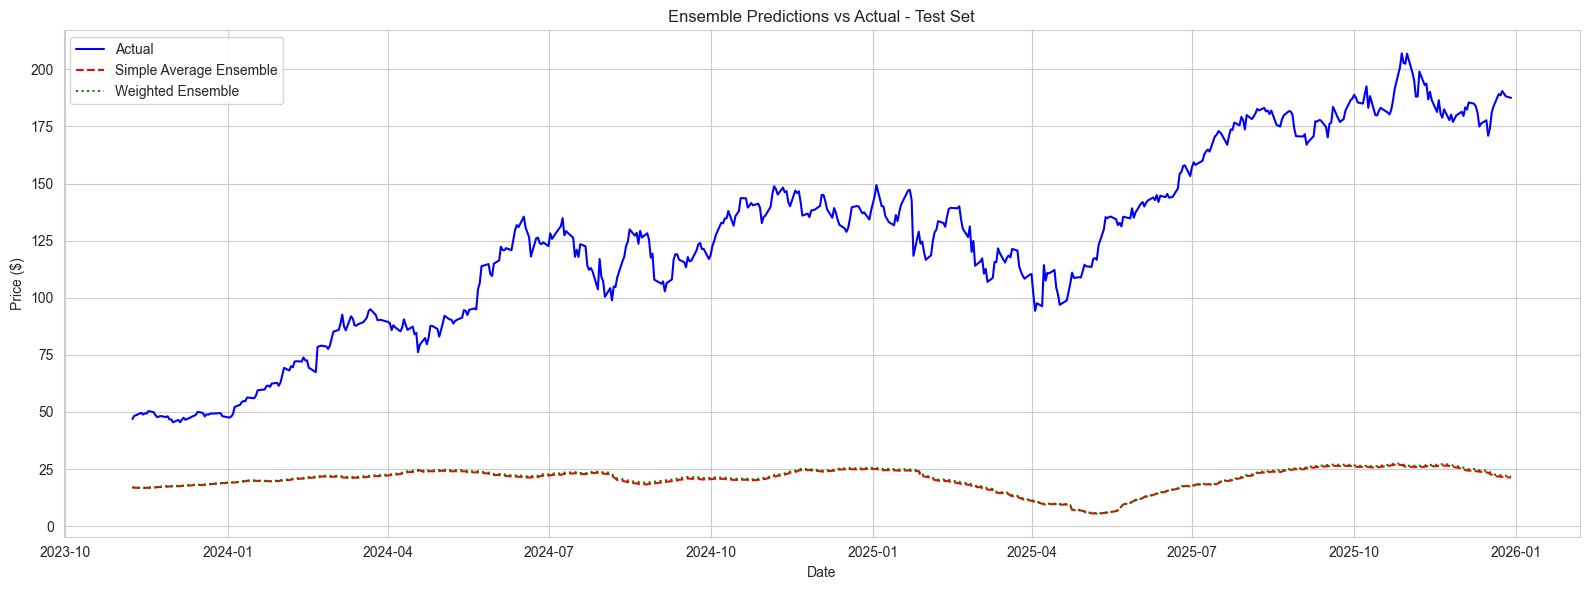

In [242]:
# Cell 105: Plot ensemble predictions vs actual
plt.figure(figsize=(16, 6))
plt.plot(test_seq_dates, y_test_actual, label='Actual', color='blue', linewidth=1.5)
plt.plot(test_seq_dates, ensemble_simple_avg, label='Simple Average Ensemble', color='red', linestyle='--', linewidth=1.5)
if 'weighted_pred' in locals():
    plt.plot(test_seq_dates, weighted_pred, label='Weighted Ensemble', color='green', linestyle=':', linewidth=1.5)
plt.title('Ensemble Predictions vs Actual - Test Set')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PROCESSED_DATA_PATH, "ensemble_predictions.png"))
plt.show()

In [243]:
# Cell 106: Save ensemble predictions
ensemble_results = pd.DataFrame({
    'date': test_seq_dates,
    'actual': y_test_actual,
    'simple_avg_ensemble': ensemble_simple_avg
})
if 'weighted_pred' in locals():
    ensemble_results['weighted_ensemble'] = weighted_pred
ensemble_results.to_csv(os.path.join(PROCESSED_DATA_PATH, "ensemble_test_results.csv"), index=False)

logger.info("Phase 9 complete. Ensemble model evaluated.")

2026-02-18 21:11:51,687 - INFO - Phase 9 complete. Ensemble model evaluated.
